# Importar Bibliotecas

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
%matplotlib inline
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import json
#!pip install folium
import folium
from folium.features import GeoJsonTooltip
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

# Carga de Datos

In [5]:
# Dataset Train
path = r"C:\Users\brusa\LucasBrusasca\Data_Science\UA_MDM_Labo2\input\petfinder-adoption-prediction\train\train.csv"

# === Cargar datasets auxiliares ===
state_labels = pd.read_csv(r"C:\Users\brusa\LucasBrusasca\Data_Science\UA_MDM_Labo2\input\petfinder-adoption-prediction\state_labels.csv")

with open(r"C:\Users\brusa\LucasBrusasca\Data_Science\UA_MDM_Labo2\input\petfinder-adoption-prediction\geoBoundaries-MYS-ADM1_simplified.geojson", encoding="utf-8") as f:
    geojson_data = json.load(f)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\brusa\\LucasBrusasca\\Data_Science\\UA_MDM_Labo2\\input\\petfinder-adoption-prediction\\state_labels.csv'

In [139]:
df = pd.read_csv(path)
df.head(3)

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   

   MaturitySize  ...  Health  Quantity  Fee  State  \
0             1  ...       1         1  100  41326   
1             2  ...       1         1    0  41401   
2             2  ...       1         1    0  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   
1  3082c7125d8fb66f7dd4bff4192c8b14         0   
2  fa90fa5b1ee11c86938398b60abc32cb         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   
1  I just found it alone yesterday near my apartm...  6296e909a      2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906      7.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  

[3 rows x 24 columns]

# EDA

In [140]:
df.shape

(14993, 24)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [142]:
df.isna().sum()

Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

**Las variables Name y Description tienen nulos.**

## 🐾 Metadatos del Dataset de PetFinder

A continuación se detallan las variables incluidas en el dataset, junto con su significado y codificación:

---

| 🏷️ **Variable**     | 📝 **Descripción** |
|----------------------|--------------------|
| `PetID`              | 🔑 Identificador único del perfil de la mascota (formato hash). |
| `AdoptionSpeed`      | ⏱️ Velocidad de adopción (**target**). Cuanto más bajo, más rápido fue adoptado. |
| `Type`               | 🐶 Tipo de animal (1 = Perro, 2 = Gato). |
| `Name`               | 🐾 Nombre de la mascota (puede estar vacío si no fue nombrada). |
| `Age`                | 🎂 Edad en meses. |
| `Breed1`             | 🧬 Raza principal (ver diccionario `BreedLabels`). |
| `Breed2`             | 🧬 Raza secundaria (0 si no aplica). |
| `Gender`             | 🚻 Género (1 = Macho, 2 = Hembra, 3 = Mixto/grupo). |
| `Color1`             | 🎨 Color primario (ver `ColorLabels`). |
| `Color2`             | 🎨 Color secundario. |
| `Color3`             | 🎨 Color terciario. |
| `MaturitySize`       | 📏 Tamaño en la adultez (1 = Pequeño, 2 = Mediano, 3 = Grande, 4 = Extra grande, 0 = No especificado). |
| `FurLength`          | ✂️ Largo del pelaje (1 = Corto, 2 = Medio, 3 = Largo, 0 = No especificado). |
| `Vaccinated`         | 💉 ¿Vacunado? (1 = Sí, 2 = No, 3 = No seguro). |
| `Dewormed`           | 🪱 ¿Desparasitado? (1 = Sí, 2 = No, 3 = No seguro). |
| `Sterilized`         | 🚫 ¿Esterilizado/castrado? (1 = Sí, 2 = No, 3 = No seguro). |
| `Health`             | ❤️ Estado de salud (1 = Saludable, 2 = Lesión leve, 3 = Lesión grave, 0 = No especificado). |
| `Quantity`           | 🔢 Número de mascotas en el perfil. |
| `Fee`                | 💸 Tarifa de adopción (0 = Gratis). |
| `State`              | 🌍 Estado o región de Malasia (ver `StateLabels`). |
| `RescuerID`          | 🆔 ID único del rescatista. |
| `VideoAmt`           | 🎥 Cantidad de videos publicados. |
| `PhotoAmt`           | 📸 Cantidad de fotos subidas. |
| `Description`        | 📝 Descripción libre del perfil (en inglés, malayo o chino). |

---

## 🎯 Variable Objetivo: `AdoptionSpeed`

Esta variable representa **qué tan rápido fue adoptada una mascota** desde que fue publicada. Es una **variable categórica ordinal**, ya que sus valores indican un orden temporal (de adopción más rápida a más lenta).

---

### 🐾 Significado de los valores

| Valor | Interpretación        | Tiempo desde la publicación             |
|-------|------------------------|------------------------------------------|
| **0** | 🟢 Adopción inmediata  | El mismo día en que fue publicada        |
| **1** | 🟡 Adopción rápida     | Entre 1 y 7 días (dentro de la 1° semana)|
| **2** | 🟠 Adopción moderada   | Entre 8 y 30 días (dentro del 1° mes)    |
| **3** | 🔴 Adopción lenta      | Entre 31 y 90 días (2° y 3° mes)         |
| **4** | ⚫ Sin adopción         | Más de 100 días (no hay casos entre 90 y 100 días) |

---

### 📌 Notas importantes

- `AdoptionSpeed` clasifica el éxito de adopción en distintos niveles de rapidez.
- Al ser **ordinal**, tiene una jerarquía natural: `0 < 1 < 2 < 3 < 4`.
- La categoría `4` representa **casos donde no se logró la adopción**, y es la única sin un rango intermedio claro entre 90 y 100 días.

---

# Análisis Univariado

# Limpiar
* Reemplazar nulos por 'Unnamed'
* Crear columna con has_Name, booleana, si tiene nombre o es unnamed (y description es vacío)
* Verificar caracteres especiales, nombres raros, números, etc

## Type

In [143]:
type_counts = df['Type'].value_counts(dropna=False)
type_counts

Type
1    8132
2    6861
Name: count, dtype: int64

In [144]:
dif_cant_tipo = type_counts.iloc[0] - type_counts.iloc[1]
print(f'Diferencia entre perros y gatos: {dif_cant_tipo}')

Diferencia entre perros y gatos: 1271


In [145]:
type_counts.rename({1:'Perro', 2:'Gato'}, inplace=True)

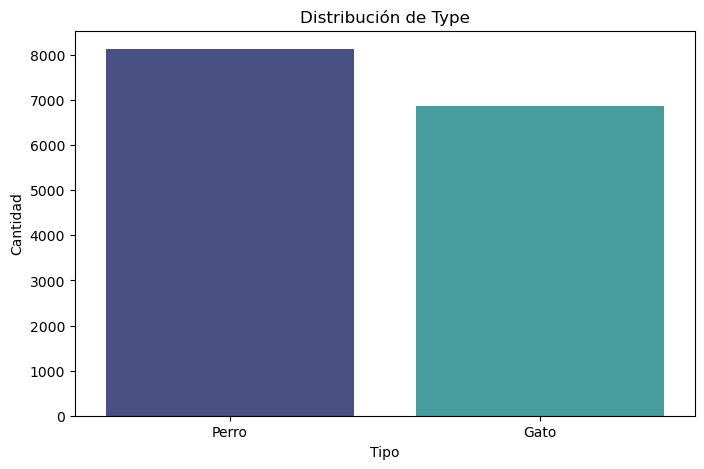

In [146]:
plt.figure(figsize=(8,5))
plt.title("Distribución de Type")
plt.ylabel("Cantidad")
plt.xlabel("Tipo")
sns.barplot(x=type_counts.index, y=type_counts.values, palette='mako');

**Se puede observar que hay 8132 perros y 6861 gatos en el dataset, con una diferencia de 1271 a favor de los perros, indicando que la variable Type está desbalanceada.**

## Name

In [147]:
df['Name'].value_counts(dropna=False)

Name
NaN                   1265
Baby                    66
Lucky                   64
No Name                 54
Brownie                 54
                      ... 
Boceyyy                  1
Panbe                    1
Doremon                  1
Sentul Kittiens          1
Little Lucky Latte       1
Name: count, Length: 9060, dtype: int64

In [148]:
np.set_printoptions(threshold=np.inf)
df['Name'].unique()[:50]

array(['Nibble', 'No Name Yet', 'Brisco', 'Miko', 'Hunter', nan, 'BULAT',
       'Siu Pak & Her 6 Puppies', 'Kitty', 'Bear', 'Kali', 'Peanut',
       '2 Mths Old Cute Kitties', 'Lost Dog', 'Max', 'Brownie', 'Blackie',
       'Beauty', 'Godiva', 'Tigers', 'Kenit, Kenot, Techit, Keyad, Owen',
       'Donut', 'Cikenet', 'Garfield', 'No Name', 'Pepper',
       'Benji & Kimi', 'Kekok', 'BoiBoi', 'Kitten Girl Girl', 'Tom',
       'Comel', 'WHISKY', 'Boy', 'Angel',
       'Drax Aka Fatso, Quill & Rocket', 'Novy', 'Jack', 'Xiao Gou',
       'Blackie & Spotty', 'Cimpuk', 'Lollipop', 'Cute Puppies', 'Alang',
       'Blackie Duo', 'Cedric Jones', 'BouncerBoy: Beagle Mix', 'Mummies',
       'Dusty', 'Kitties'], dtype=object)

**Luego de examinar superficialmente la variable Name, es necesario realizar limpieza.**

In [149]:
# Capitalizar nombres
df['Name'] = df['Name'].str.capitalize()
df['Name'].value_counts(dropna=False)

Name
NaN                1265
Baby                 67
Lucky                66
Mimi                 59
Brownie              55
                   ... 
Boceyyy               1
Panbe                 1
Doremon               1
Sentul kittiens       1
Lost dog              1
Name: count, Length: 8846, dtype: int64

In [150]:
# Reemplazar nulos por 'Unnamed'
df['Name'] = df['Name'].fillna('Unnamed')
df['Name'].value_counts(dropna=False)

Name
Unnamed            1271
Baby                 67
Lucky                66
Mimi                 59
Brownie              55
                   ... 
Boceyyy               1
Panbe                 1
Doremon               1
Sentul kittiens       1
Cik tom               1
Name: count, Length: 8845, dtype: int64

In [151]:
# Reemplazar 'No Name Yet' por 'Unnamed'
df['Name'] = df['Name'].str.replace('No Name Yet', 'Unnamed')
df['Name'].value_counts(dropna=False)

Name
Unnamed            1271
Baby                 67
Lucky                66
Mimi                 59
Brownie              55
                   ... 
Boceyyy               1
Panbe                 1
Doremon               1
Sentul kittiens       1
Cik tom               1
Name: count, Length: 8845, dtype: int64

In [152]:
# Evaluar casos con et
df['Name'][df['Name'].str.contains('&')].values[:50]

array(['Siu pak & her 6 puppies', 'Benji & kimi',
       'Drax aka fatso, quill & rocket', 'Blackie & spotty', 'Bill & ben',
       'Pebbles & pepper', 'Kiki & lala', 'Kt(female) & tm (male)',
       'Ibu & kitten yg diabaikan', 'Jackjack (black)& turtle (tor.shell',
       'Wong & choi', 'Rhapsody, bay, harmony, classic & symph',
       'Name them & love them 2', 'Mama & her 3 babies',
       'Giant, cookie & snoopy. ! thanks!', 'Putih & belang',
       'Mak ning & cik tam', 'Oren & comot', 'Xiao hei & xiao bai',
       'Orey & yo', 'Milk milk & mio mio', 'Torti & black',
       'Lipstick & ashton', 'Kopi-o & milo', 'Charlie & harry',
       'Nottie & choomi', 'Pearl & her kitties', 'Paris & london',
       'Mocha &latte (can be renamed)', 'Nescafe, coffee & horlicks',
       'Shatam & tam tam', 'Black & white kitten (lila)', 'Bob & marley',
       'Cat & kitten for adoption', 'Muffin & cookie (neutered)',
       'Nala & peach', 'Nonny & boink family', 'Leo & lulu',
       'Forrest & 

In [153]:
# Reemplazar , por & con espacios
df['Name'] = df['Name'].str.replace(',', ' & ')
df['Name'].value_counts(dropna=False)

Name
Unnamed            1271
Baby                 67
Lucky                66
Mimi                 59
Brownie              55
                   ... 
Boceyyy               1
Panbe                 1
Doremon               1
Sentul kittiens       1
Cik tom               1
Name: count, Length: 8845, dtype: int64

In [154]:
# Eliminar caracteres especiales pero mantener '&' debido a que un registro puede indicar múltiples animales
df['Name'] = df['Name'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s&]', '', x))
df['Name'].value_counts(dropna=False)

Name
Unnamed       1272
Baby            67
Lucky           66
Mimi            60
Brownie         56
              ... 
Kofi annan       1
Zee4             1
Ang ang          1
Wormmy           1
Dak kunyit       1
Name: count, Length: 8747, dtype: int64

In [155]:
df['Name'][df['Name'].str.contains('named')].unique()

array(['Unnamed', 'Not yet named', 'Mocha &latte can be renamed',
       '1 year kitten named mia at damansara', ' to be named ',
       'Unamed yet 2', 'Unamed', 'Unnamed 3 kittens  by dani',
       'Not named yet', 'To be named by owner', 'Not named',
       'Kitty not named yet', 'Havent been named', 'No named',
       'Unnamed cats for adoption', 'Havent named them', 'Unamed yet',
       'Black dog  lucky named by rescurer', 'Cream cat unnamed'],
      dtype=object)

In [156]:
df['Name'][df['Name']=='nan']

Series([], Name: Name, dtype: object)

In [157]:
rep_name_pattern = '|'.join(
    [
        'Not yet named', 
        ' to be named ', 
        'Unamed yet 2', 
        'Unamed', 
        'Unnamed 3 kittens  by dani', 
        'Not named yet', 
        'To be named by owner', 
        'Not named',
        'Kitty not named yet', 
        'Havent been named', 
        'No named',
        'Unnamed cats for adoption', 
        'Havent named them', 
        'Unamed yet',
        'Cream cat unnamed'
    ])


df['Name'] = df['Name'].str.replace(rep_name_pattern, 'Unnamed', regex=True)
df['Name'].value_counts(dropna=False)

Name
Unnamed               1291
Baby                    67
Lucky                   66
Mimi                    60
Brownie                 56
                      ... 
Boceyyy                  1
Panbe                    1
Doremon                  1
Sentul kittiens          1
Little lucky latte       1
Name: count, Length: 8733, dtype: int64

In [158]:
df['Name'][df['Name'] == '']

1002     
1139     
1182     
1974     
2010     
2107     
2552     
2872     
3267     
3533     
3563     
4176     
4356     
4363     
4742     
4846     
5039     
6482     
6926     
7508     
8212     
9259     
10000    
10623    
10877    
10907    
11196    
12553    
13518    
14593    
14842    
Name: Name, dtype: object

In [159]:
df.loc[df["Name"].str.strip() == "", "Name"] = "Unnamed"
df['Name'][df['Name'] == '']

Series([], Name: Name, dtype: object)

In [160]:
df['Name'].value_counts(dropna=False)

Name
Unnamed                    1324
Baby                         67
Lucky                        66
Mimi                         60
Brownie                      56
                           ... 
Ang ang                       1
Zee4                          1
Kofi annan                    1
Omari                         1
Kl puppies for adoption       1
Name: count, Length: 8730, dtype: int64

In [161]:
df['Name'][df['Name'].str.lower().isin(['name', 'no'])]

Series([], Name: Name, dtype: object)

### Crear Variable HasName

In [162]:
# Crear variable HasName
df['HasName'] = df['Name'] != 'Unnamed'

In [163]:
hasname_counts = df['HasName'].value_counts()
hasname_counts

HasName
True     13669
False     1324
Name: count, dtype: int64

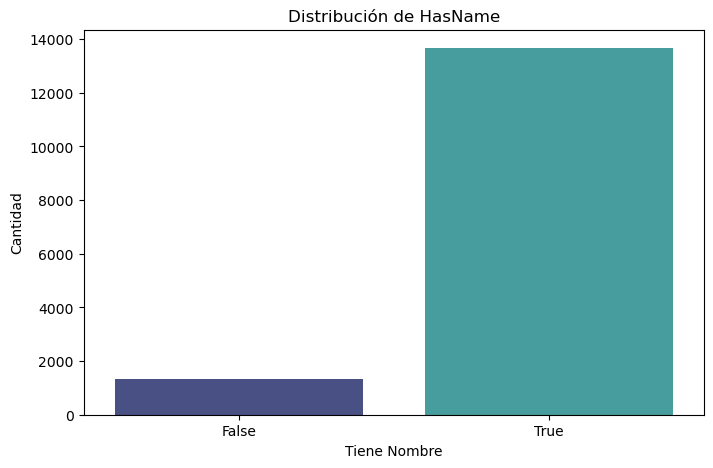

In [164]:
# Evaluar cantidad de registros con nombre
plt.figure(figsize=(8,5))
plt.title("Distribución de HasName")
plt.ylabel("Cantidad")
plt.xlabel("Tiene Nombre")
sns.barplot(x=hasname_counts.index, y=hasname_counts.values, palette='mako');

**Se puede observar que la mayoría de los animales tienen nombre.**

## Age

### Columna 'Age', armar categorías (bins), armar otra columna de 'Age_Year'

In [165]:
np.sort(df['Age'].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  72,  73,  74,  75,  76,  77,  78,  80,  81,  82,
        84,  85,  86,  87,  88,  89,  91,  92,  95,  96, 100, 102, 108,
       112, 117, 120, 122, 123, 132, 135, 144, 147, 156, 168, 180, 212,
       238, 255])

In [166]:
age_desc = df['Age'].describe()
age_desc

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64

**Se puede observar el amplio rango de edad en meses de los animales, que va de 0 a 255, con un promedio de 10.45 meses y mediana de 3 meses.**

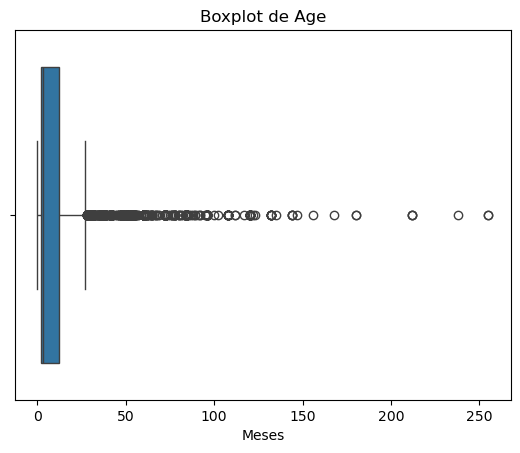

In [167]:
plt.title('Boxplot de Age')
plt.xlabel('Meses')
sns.boxplot(x=df['Age']);

In [168]:
len(df['Age'])

14993

In [169]:
age_q1 = age_desc.loc['25%']
age_q3 = age_desc.loc['75%']
age_iqr = abs(age_q3 - age_q1)
upper_bound_age = age_q3 + 1.5 * age_iqr
cant_outliers_age = len(df['Age'][df['Age'] > upper_bound_age])
print(f'Cantidad de outliers: {cant_outliers_age}')

Cantidad de outliers: 1501


In [170]:
age_counts = df['Age'].value_counts(dropna=False)[:10]
age_counts

Age
2     3503
1     2304
3     1966
4     1109
12     967
24     651
5      595
6      558
36     417
8      309
Name: count, dtype: int64

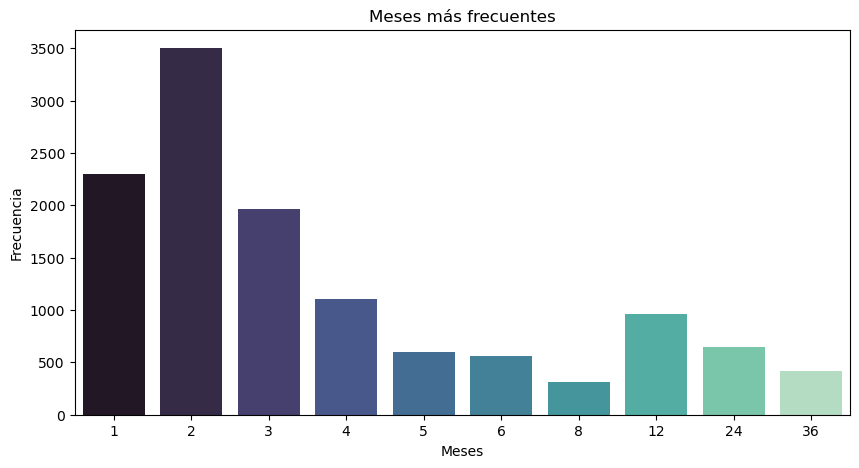

In [171]:
plt.figure(figsize=(10,5))
plt.title('Meses más frecuentes')
plt.xlabel('Meses')
plt.ylabel('Frecuencia')
sns.barplot(x=age_counts.index, y=age_counts.values, ci=None, palette='mako');

### Crear Variable AgeYear

### 💡 Nota metodológica – Variable `AgeYear`

En esta sección se crea la variable `AgeYear` como una transformación auxiliar de `Age` (edad en meses), dividiendo por 12 para facilitar la interpretación durante el análisis exploratorio.

```python
AgeYear = round(df['Age'] / 12)


In [172]:
AgeYear= round(df['Age'] / 12)

In [173]:
ageyear_counts = AgeYear.value_counts(dropna=False)
ageyear_counts.index = ageyear_counts.index.astype('int')
ageyear_counts

Age
0     10214
1      2309
2      1059
3       487
4       322
5       228
6       126
7       113
8        52
10       36
9        23
11        9
12        5
18        3
21        2
15        2
13        1
14        1
20        1
Name: count, dtype: int64

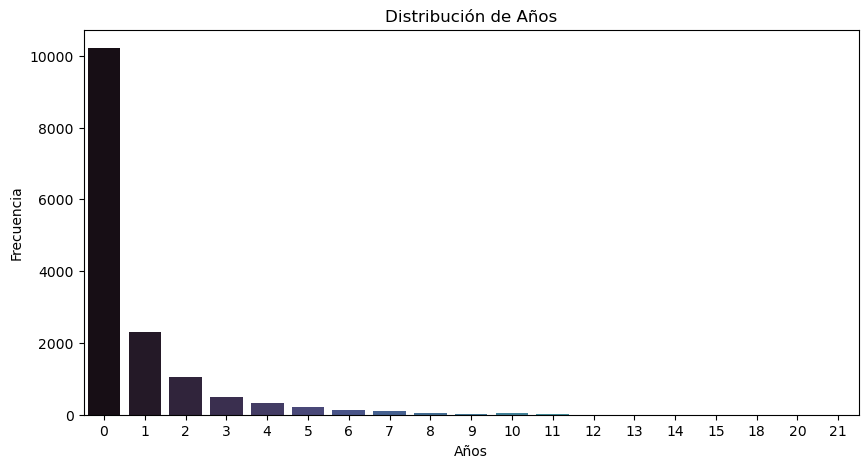

In [174]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Años')
plt.xlabel('Años')
plt.ylabel('Frecuencia')
sns.barplot(x=ageyear_counts.index, y=ageyear_counts.values, ci=None, palette='mako');

💡 A partir de esta exploración, se concluye que la variable `AgeYear` (edad en años) mejora la interpretación de la edad.  
Por lo tanto, será **incorporada** al dataset en la etapa de Feature Engineering.


## Breed1

In [175]:
top_20_breed1 = df['Breed1'].value_counts()[:20]
top_20_breed1

Breed1
307    5927
266    3634
265    1258
299     342
264     296
292     264
285     221
141     205
205     190
179     167
218     162
109     151
254     105
103      98
243      94
20       90
213      89
189      88
283      73
247      71
Name: count, dtype: int64

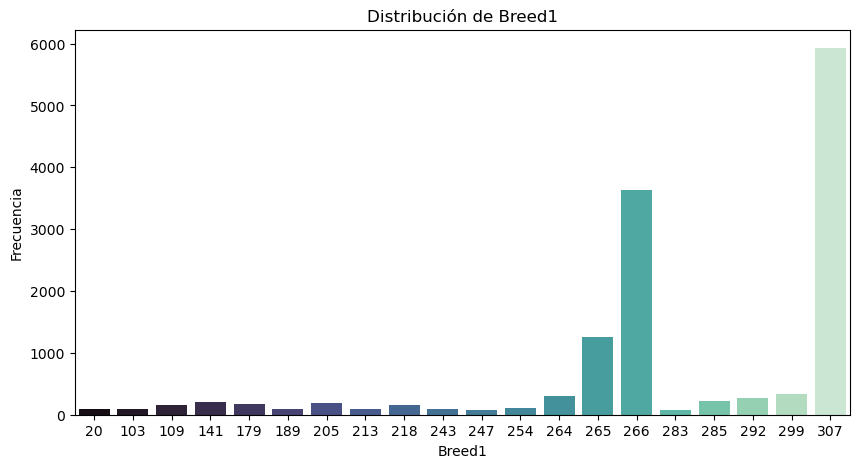

In [176]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Breed1')
plt.xlabel('Breed1')
plt.ylabel('Frecuencia')
sns.barplot(x=top_20_breed1.index, y=top_20_breed1.values, ci=None, palette='mako');

## Breed2

In [177]:
top_20_breed2 = df['Breed2'].value_counts()[:20]
top_20_breed2

Breed2
0      10762
307     1727
266      599
265      321
299      138
264      125
292      105
218       91
141       86
285       78
103       55
213       49
254       42
189       40
109       39
247       39
179       38
205       32
243       30
283       24
Name: count, dtype: int64

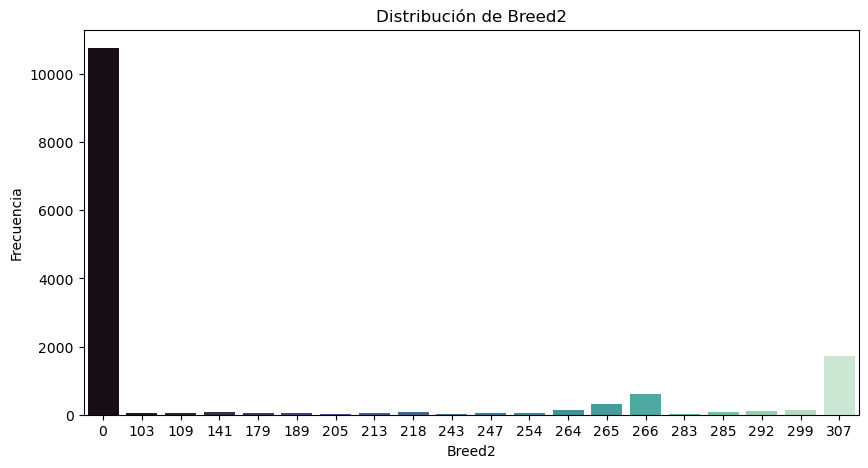

In [178]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Breed2')
plt.xlabel('Breed2')
plt.ylabel('Frecuencia')
sns.barplot(x=top_20_breed2.index, y=top_20_breed2.values, ci=None, palette='mako');

## Gender

In [179]:
gender_counts = df['Gender'].value_counts(dropna=False)
gender_counts = gender_counts.rename({1:'Macho', 2:'Hembra', 3:'Mixto'})
gender_counts

Gender
Hembra    7277
Macho     5536
Mixto     2180
Name: count, dtype: int64

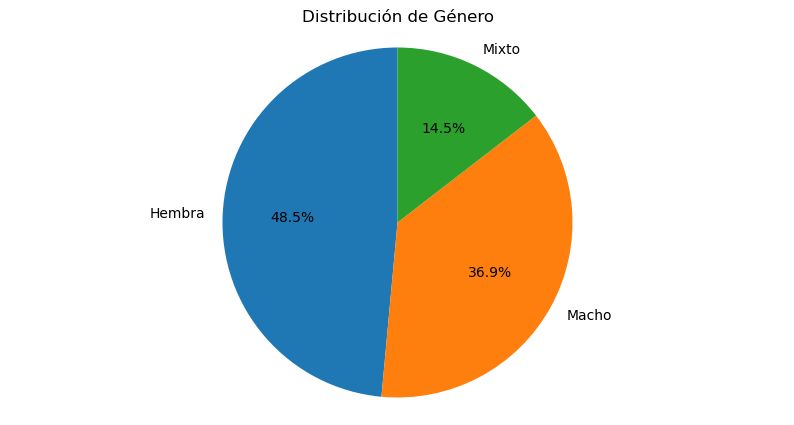

In [180]:
plt.figure(figsize=(10,5))
plt.pie(gender_counts, labels=gender_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Distribución de Género")
plt.axis("equal");

## Color1

In [181]:
color1_counts = df['Color1'].value_counts(dropna=False)
color1_counts

Color1
1    7427
2    3750
3     947
5     884
6     684
7     667
4     634
Name: count, dtype: int64

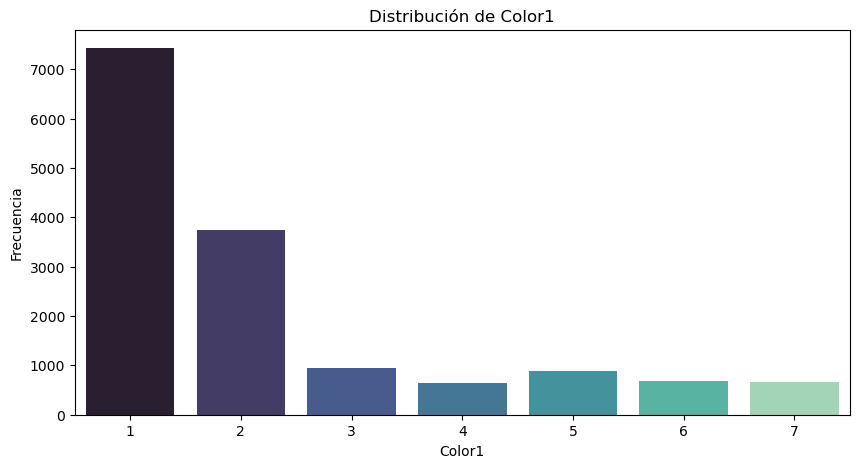

In [182]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Color1')
plt.xlabel('Color1')
plt.ylabel('Frecuencia')
sns.barplot(x=color1_counts.index, y=color1_counts.values, ci=None, palette='mako');

## Color2

In [183]:
color2_counts = df['Color2'].value_counts(dropna=False)
color2_counts

Color2
0    4471
7    3438
2    3313
5    1128
6    1063
4     870
3     710
Name: count, dtype: int64

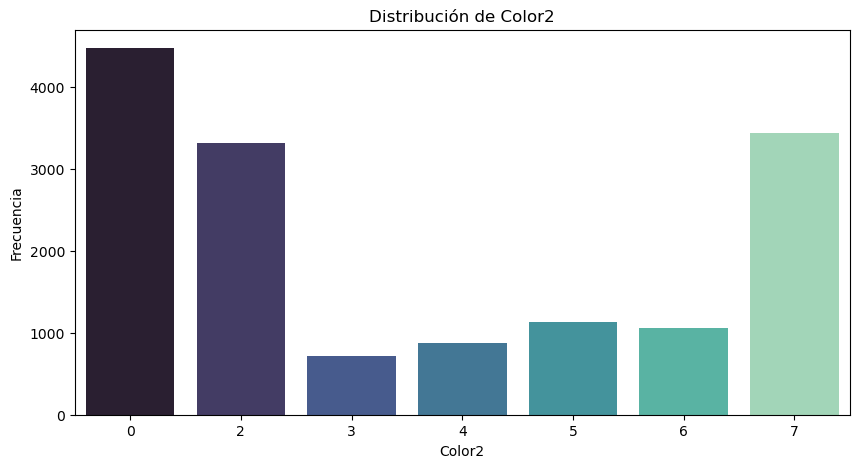

In [184]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Color2')
plt.xlabel('Color2')
plt.ylabel('Frecuencia')
sns.barplot(x=color2_counts.index, y=color2_counts.values, ci=None, palette='mako');

## Color3

In [185]:
color3_counts = df['Color3'].value_counts(dropna=False)
color3_counts

Color3
0    10604
7     3221
5      417
6      378
4      198
3      175
Name: count, dtype: int64

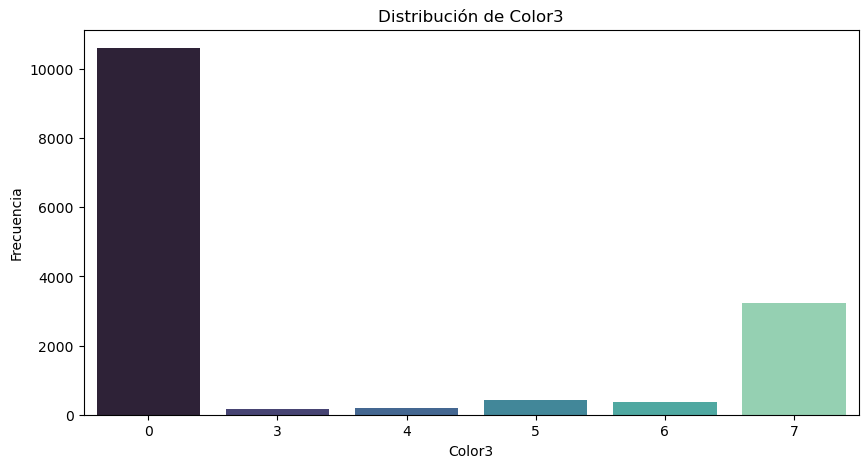

In [186]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Color3')
plt.xlabel('Color3')
plt.ylabel('Frecuencia')
sns.barplot(x=color3_counts.index, y=color3_counts.values, ci=None, palette='mako');

## MaturitySize

**Tamaño de perro en adultez.**
Agregar descripción

In [187]:
maturitysize_counts = df['MaturitySize'].value_counts(dropna=False)
maturitysize_counts = maturitysize_counts.rename(
    {
        1:'Pequeño', 
        2:'Mediano', 
        3:'Grande', 
        4:'Extra grande', 
        0:'No especificado'
    }
)
maturitysize_counts

MaturitySize
Mediano         10305
Pequeño          3395
Grande           1260
Extra grande       33
Name: count, dtype: int64

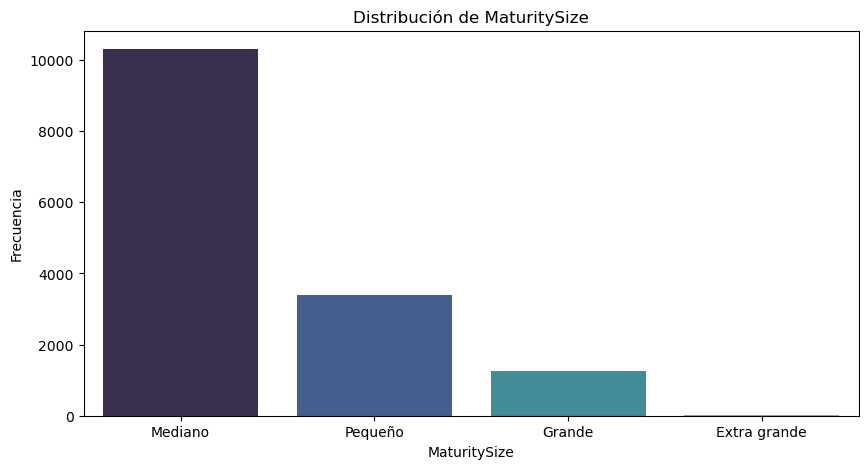

In [188]:
plt.figure(figsize=(10,5))
plt.title('Distribución de MaturitySize')
plt.xlabel('MaturitySize')
plt.ylabel('Frecuencia')
sns.barplot(x=maturitysize_counts.index, y=maturitysize_counts.values, ci=None, palette='mako');

## FurLength

In [189]:
furlength_counts = df['FurLength'].value_counts(dropna=False)
furlength_counts = furlength_counts.rename(
    {
        1:'Corto', 
        2:'Medio', 
        3:'Largo',
        0:'No especificado'
    }
)
furlength_counts

FurLength
Corto    8808
Medio    5361
Largo     824
Name: count, dtype: int64

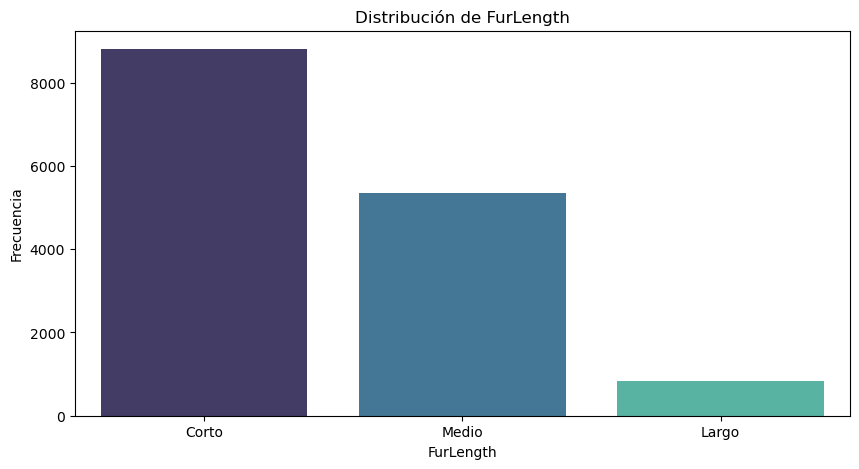

In [190]:
plt.figure(figsize=(10,5))
plt.title('Distribución de FurLength')
plt.xlabel('FurLength')
plt.ylabel('Frecuencia')
sns.barplot(x=furlength_counts.index, y=furlength_counts.values, ci=None, palette='mako');

## Vaccinated

In [191]:
vaccinated_counts = df['Vaccinated'].value_counts(dropna=False)
vaccinated_counts = vaccinated_counts.rename({
    1:'Sí',
    2:'No', 
    3:'No seguro'
})
vaccinated_counts

Vaccinated
No           7227
Sí           5898
No seguro    1868
Name: count, dtype: int64

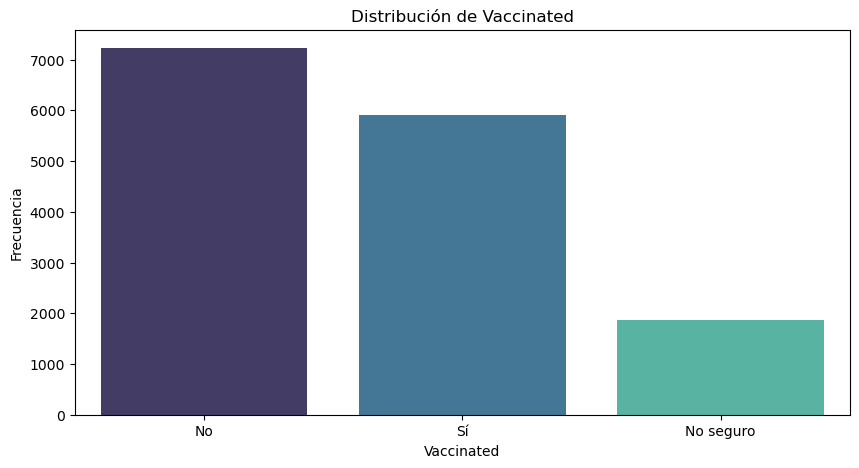

In [192]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Vaccinated')
plt.xlabel('Vaccinated')
plt.ylabel('Frecuencia')
sns.barplot(x=vaccinated_counts.index, y=vaccinated_counts.values, ci=None, palette='mako');

## Dewormed

In [193]:
dewormed_counts = df['Dewormed'].value_counts(dropna=False)
dewormed_counts = dewormed_counts.rename({
    1:'Sí',
    2:'No', 
    3:'No seguro'
})
dewormed_counts

Dewormed
Sí           8397
No           4815
No seguro    1781
Name: count, dtype: int64

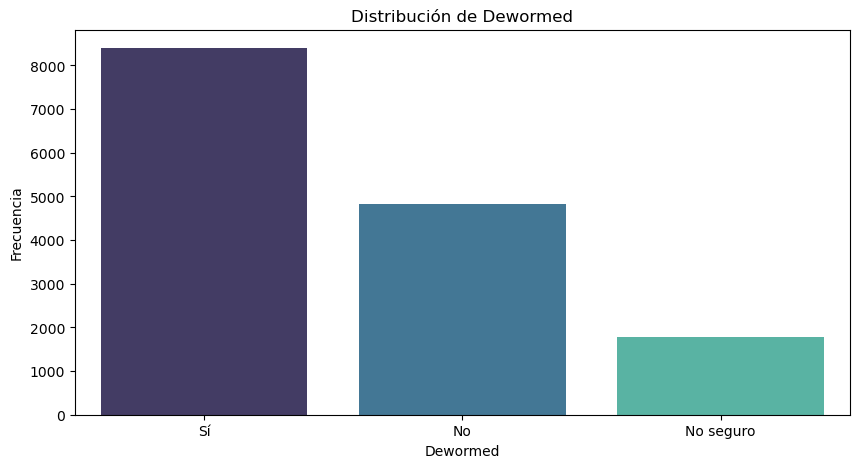

In [194]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Dewormed')
plt.xlabel('Dewormed')
plt.ylabel('Frecuencia')
sns.barplot(x=dewormed_counts.index, y=dewormed_counts.values, ci=None, palette='mako');

## Sterilized

In [195]:
sterilized_counts = df['Sterilized'].value_counts(dropna=False)
sterilized_counts = sterilized_counts.rename({
    1:'Sí',
    2:'No', 
    3:'No seguro'
})
sterilized_counts

Sterilized
No           10077
Sí            3101
No seguro     1815
Name: count, dtype: int64

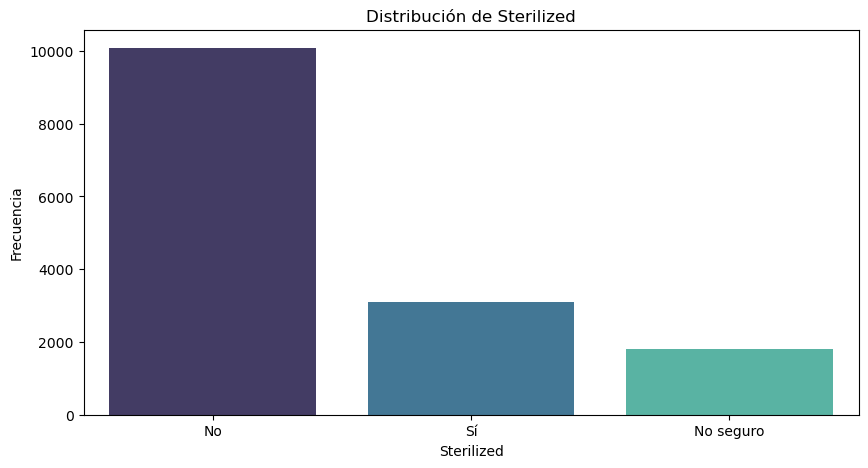

In [196]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Sterilized')
plt.xlabel('Sterilized')
plt.ylabel('Frecuencia')
sns.barplot(x=sterilized_counts.index, y=sterilized_counts.values, ci=None, palette='mako');

## Health

In [197]:
health_counts = df['Health'].value_counts(dropna=False)
health_counts = health_counts.rename({
    1:'Saludable',
    2:'Lesión leve', 
    3:'Lesión grave',
    4:'No especificado'
})
health_counts

Health
Saludable       14478
Lesión leve       481
Lesión grave       34
Name: count, dtype: int64

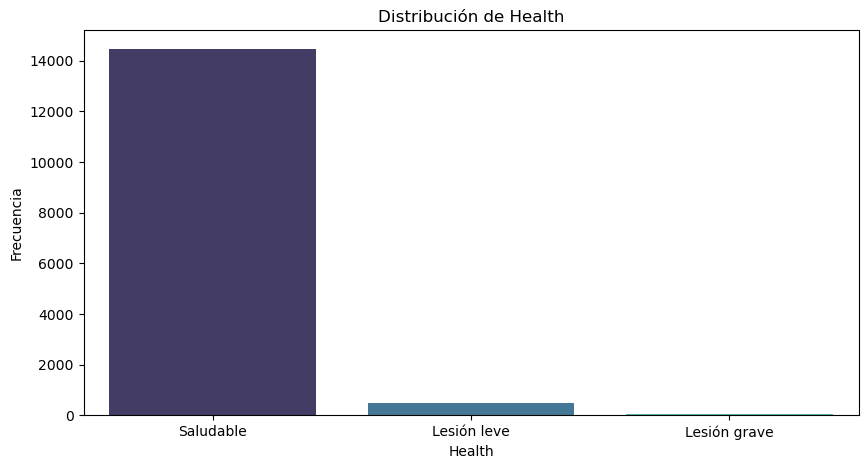

In [198]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Health')
plt.xlabel('Health')
plt.ylabel('Frecuencia')
sns.barplot(x=health_counts.index, y=health_counts.values, ci=None, palette='mako');

## Quantity

In [199]:
quantity_counts = df['Quantity'].value_counts(dropna=False)
quantity_counts

Quantity
1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
20       12
11       10
12        6
15        4
17        3
16        3
14        2
13        2
18        1
Name: count, dtype: int64

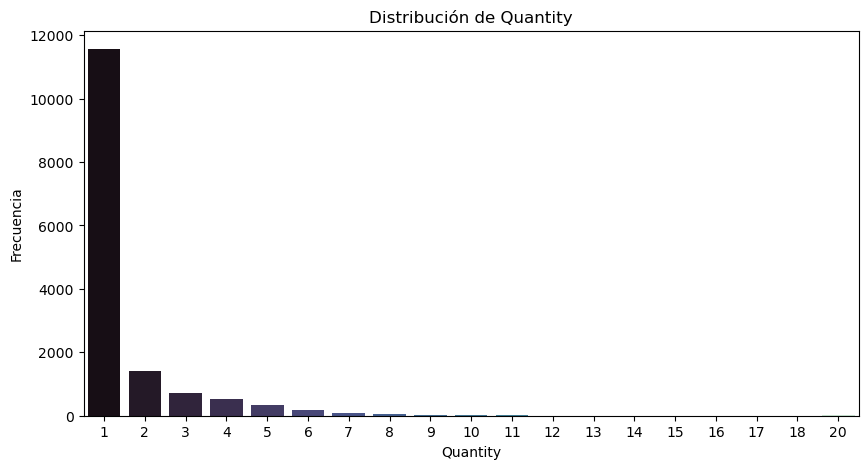

In [200]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frecuencia')
sns.barplot(x=quantity_counts.index, y=quantity_counts.values, ci=None, palette='mako');

## Fee

In [201]:
fee_counts = df['Fee'].value_counts(dropna=False)[:10]
fee_counts

Fee
0      12663
50       468
100      408
200      219
150      162
20       136
300      120
30       103
250       92
1         82
Name: count, dtype: int64

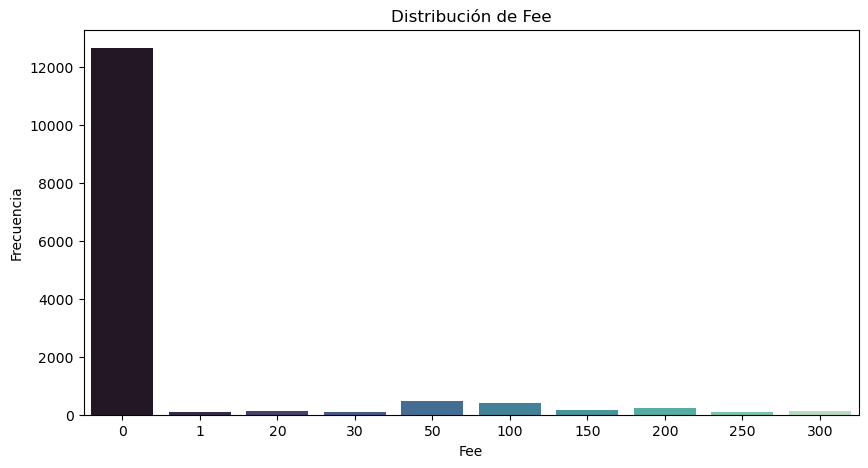

In [202]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Fee')
plt.xlabel('Fee')
plt.ylabel('Frecuencia')
sns.barplot(x=fee_counts.index, y=fee_counts.values, ci=None, palette='mako');

### Crear Variable Free

In [203]:
df['Free'] = df['Fee'] == 0

In [204]:
free_counts = df['Free'].value_counts()
free_counts

Free
True     12663
False     2330
Name: count, dtype: int64

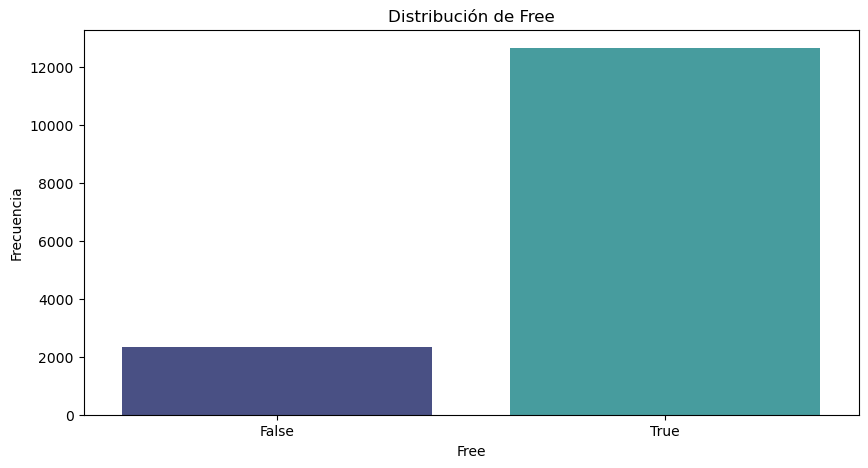

In [205]:
plt.figure(figsize=(10,5))
plt.title('Distribución de Free')
plt.xlabel('Free')
plt.ylabel('Frecuencia')
sns.barplot(x=free_counts.index, y=free_counts.values, ci=None, palette='mako');

* Cruzar con razas, ver si las razas no callejeras son caras
* Ver el 0
* Armar columna booleana, gratis vs pago

## State

In [206]:
state_counts = df['State'].value_counts(dropna=False)
state_counts

State
41326    8714
41401    3845
41327     843
41336     507
41330     420
41332     253
41324     137
41325     110
41335      85
41361      26
41345      22
41367      15
41342      13
41415       3
Name: count, dtype: int64

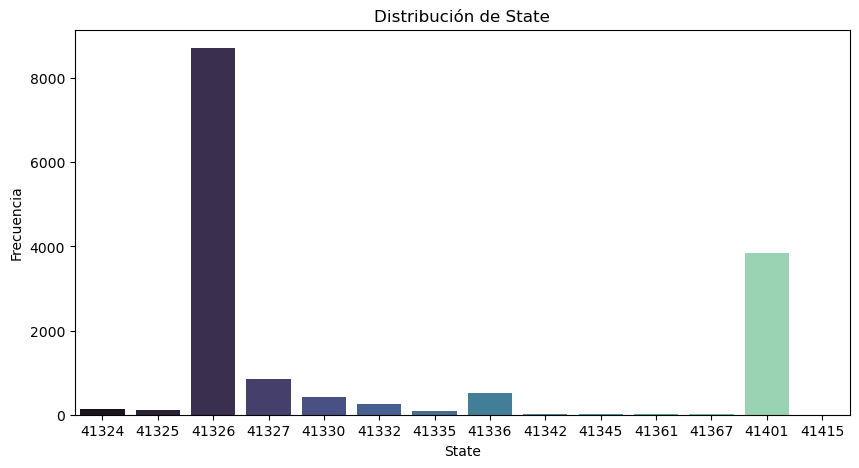

In [207]:
plt.figure(figsize=(10,5))
plt.title('Distribución de State')
plt.xlabel('State')
plt.ylabel('Frecuencia')
sns.barplot(x=state_counts.index, y=state_counts.values, ci=None, palette='mako');

Armar visualización, mapita

## RescuerID

In [208]:
cant_rescatistas = df['RescuerID'].nunique()
cant_rescatistas

5595

In [209]:
rescuer_counts = df['RescuerID'].value_counts()
rescuer_counts

RescuerID
fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
                                   ... 
ade757afc628d15ecb729163176dda69      1
1b725527b0e9af07aa6297fa52efa59a      1
61bd187b6069ac9778d92b6f9b77b0dd      1
747e1295e2d18a2928843dc9f42f58e3      1
191096c47a2beea98da1c9b37db932d6      1
Name: count, Length: 5595, dtype: int64

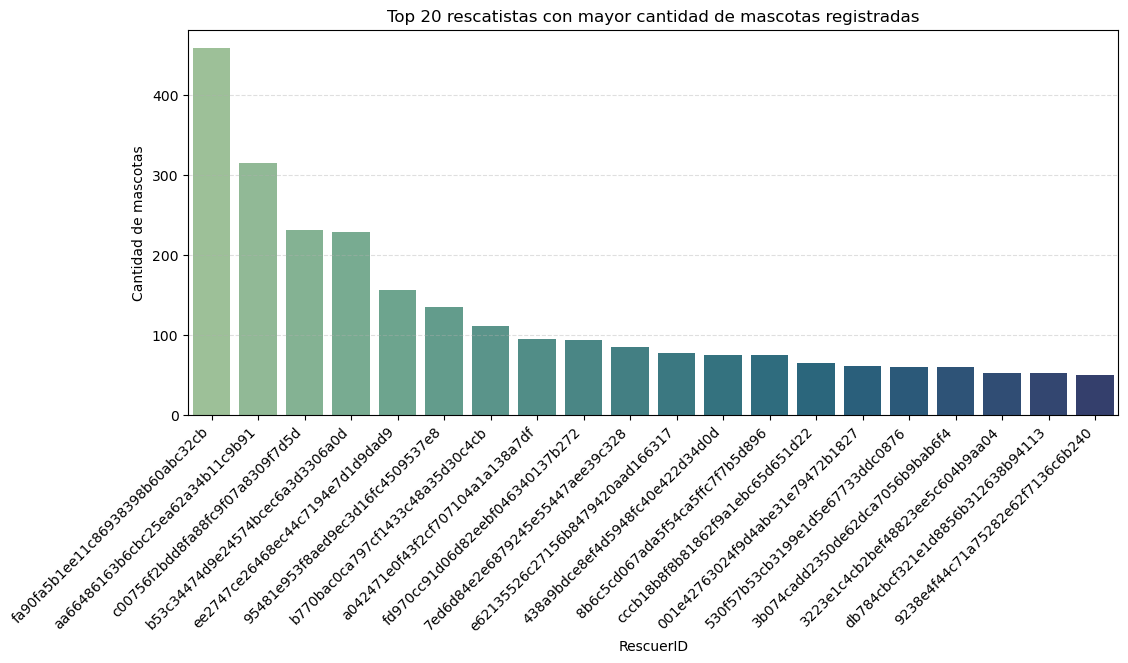

In [210]:
top_20 = rescuer_counts.sort_values(ascending=False).head(20)

plt.figure(figsize=(12,5))
sns.barplot(x=top_20.index, y=top_20.values, palette='crest')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 rescatistas con mayor cantidad de mascotas registradas')
plt.ylabel('Cantidad de mascotas')
plt.xlabel('RescuerID')
plt.grid(axis='y', linestyle='--', alpha=0.4)




### Distribución de actividad de rescatistas

El gráfico muestra a los 20 rescatistas que más mascotas registraron en el dataset.

💡 Se observa una clara concentración de actividad: un grupo muy reducido supera las 100 o incluso 400 mascotas, mientras que la mayoría registra cantidades significativamente menores.

🔍 Este patrón podría reflejar diferencias en la experiencia, reputación o capacidad de gestión de cada rescatista, y podría ser relevante para el modelado posterior. Se considera crear una feature representativa de esta actividad (`RescuerActivity`) en la etapa de Feature Engineering.


## VideoAmt

In [211]:
videoamt_counts = df['VideoAmt'].value_counts(dropna=False)
videoamt_counts

VideoAmt
0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: count, dtype: int64

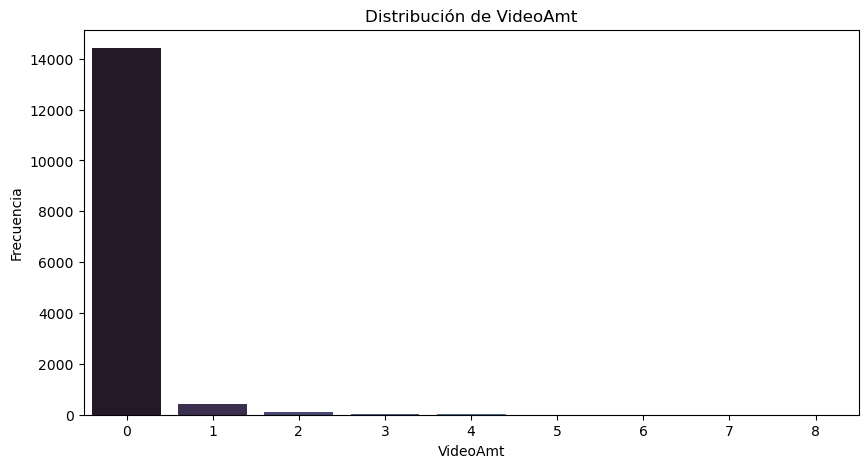

In [212]:
plt.figure(figsize=(10,5))
plt.title('Distribución de VideoAmt')
plt.xlabel('VideoAmt')
plt.ylabel('Frecuencia')
sns.barplot(x=videoamt_counts.index, y=videoamt_counts.values, ci=None, palette='mako');

## Description

In [213]:
df['Description'].value_counts(dropna=False)[:5]

Description
For Adoption        164
Dog 4 Adoption       54
Cat for adoption     25
Friendly             20
Dog for adoption     18
Name: count, dtype: int64

## PetID

In [214]:
df['PetID'].duplicated(keep=False).any()

np.False_

**No hay ids de animales duplicados.**

## PhotoAmt

In [215]:
photoamt_counts = df['PhotoAmt'].value_counts(dropna=False)
photoamt_counts.index = photoamt_counts.index.astype('int')
photoamt_counts

PhotoAmt
1     3075
2     2518
3     2511
5     2147
4     1881
6      621
7      432
0      341
8      314
9      231
10     190
11     184
12      97
13      86
14      78
15      50
16      39
17      27
20      25
19      20
30      19
18      18
21      16
24      15
23      12
26      10
22       9
25       8
28       7
27       6
29       6
Name: count, dtype: int64

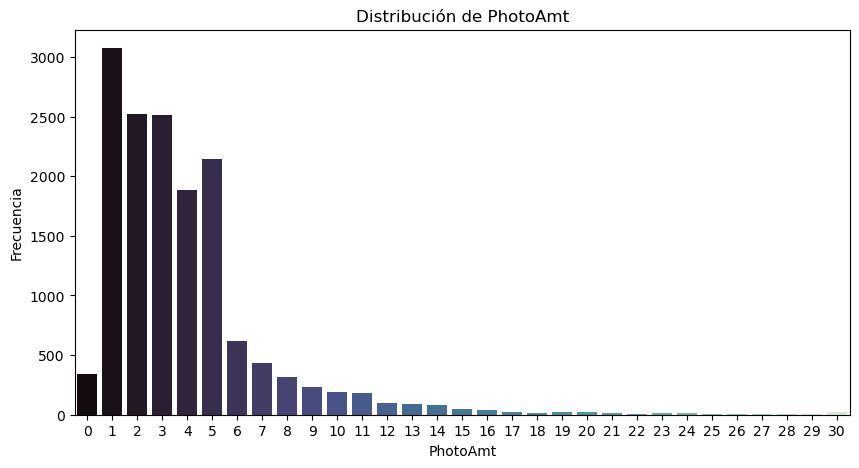

In [216]:
plt.figure(figsize=(10,5))
plt.title('Distribución de PhotoAmt')
plt.xlabel('PhotoAmt')
plt.ylabel('Frecuencia')
sns.barplot(x=photoamt_counts.index, y=photoamt_counts.values, ci=None, palette='mako');

## AdoptionSpeed

In [217]:
adoptionspeed_counts = df['AdoptionSpeed'].value_counts(dropna=False)
adoptionspeed_counts

AdoptionSpeed
4    4197
2    4037
3    3259
1    3090
0     410
Name: count, dtype: int64

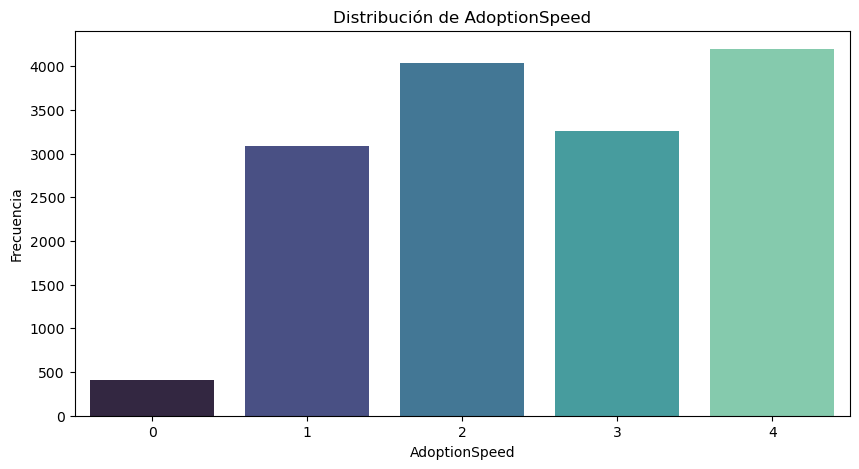

In [218]:
plt.figure(figsize=(10,5))
plt.title('Distribución de AdoptionSpeed')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Frecuencia')
sns.barplot(x=adoptionspeed_counts.index, y=adoptionspeed_counts.values, ci=None, palette='mako');

* PhotoAmt, ver cantidad de fotos, relación con AdotionSpeed

In [219]:
df.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'HasName', 'Free'],
      dtype='object')

# 📊 Análisis Multivariado

En esta sección exploraremos cómo se relacionan múltiples variables del dataset entre sí, y particularmente con la variable objetivo `AdoptionSpeed`.

El análisis multivariado permite:
- Detectar asociaciones entre variables que pueden influir en la velocidad de adopción.
- Identificar patrones que no serían visibles en un análisis univariado.
- Evaluar posibles redundancias entre variables (correlación entre predictoras).
- Servir de base para una futura selección de variables y modelado predictivo.

El enfoque estará dividido en tres grandes partes:

1. **Estructura interna** del dataset (correlación entre variables predictoras).
2. **Relación entre variables predictoras y la variable objetivo `AdoptionSpeed`**, tanto numéricas como categóricas.
3. **Importancia relativa de variables** mediante un modelo exploratorio.

Este análisis busca no solo visualizar relaciones, sino **interpretarlas con profundidad**, para sentar una base sólida para cualquier modelo que se construya más adelante.


## 🔹 1. Estructura Interna del Dataset: Correlación entre Variables Predictoras

Antes de analizar cómo las variables influyen en la adopción, es fundamental entender **cómo se relacionan entre sí** las variables predictoras.

Este análisis nos permite:
- Detectar **multicolinealidad** (cuando dos o más variables están altamente correlacionadas).
- Identificar posibles **redundancias** que podrían afectar modelos futuros.
- Entender si algunas variables aportan información similar.

Para ello, construimos un **heatmap de correlaciones** entre todas las variables numéricas.


Text(0.5, 1.0, 'Correlación entre variables numéricas (sin simetría)')

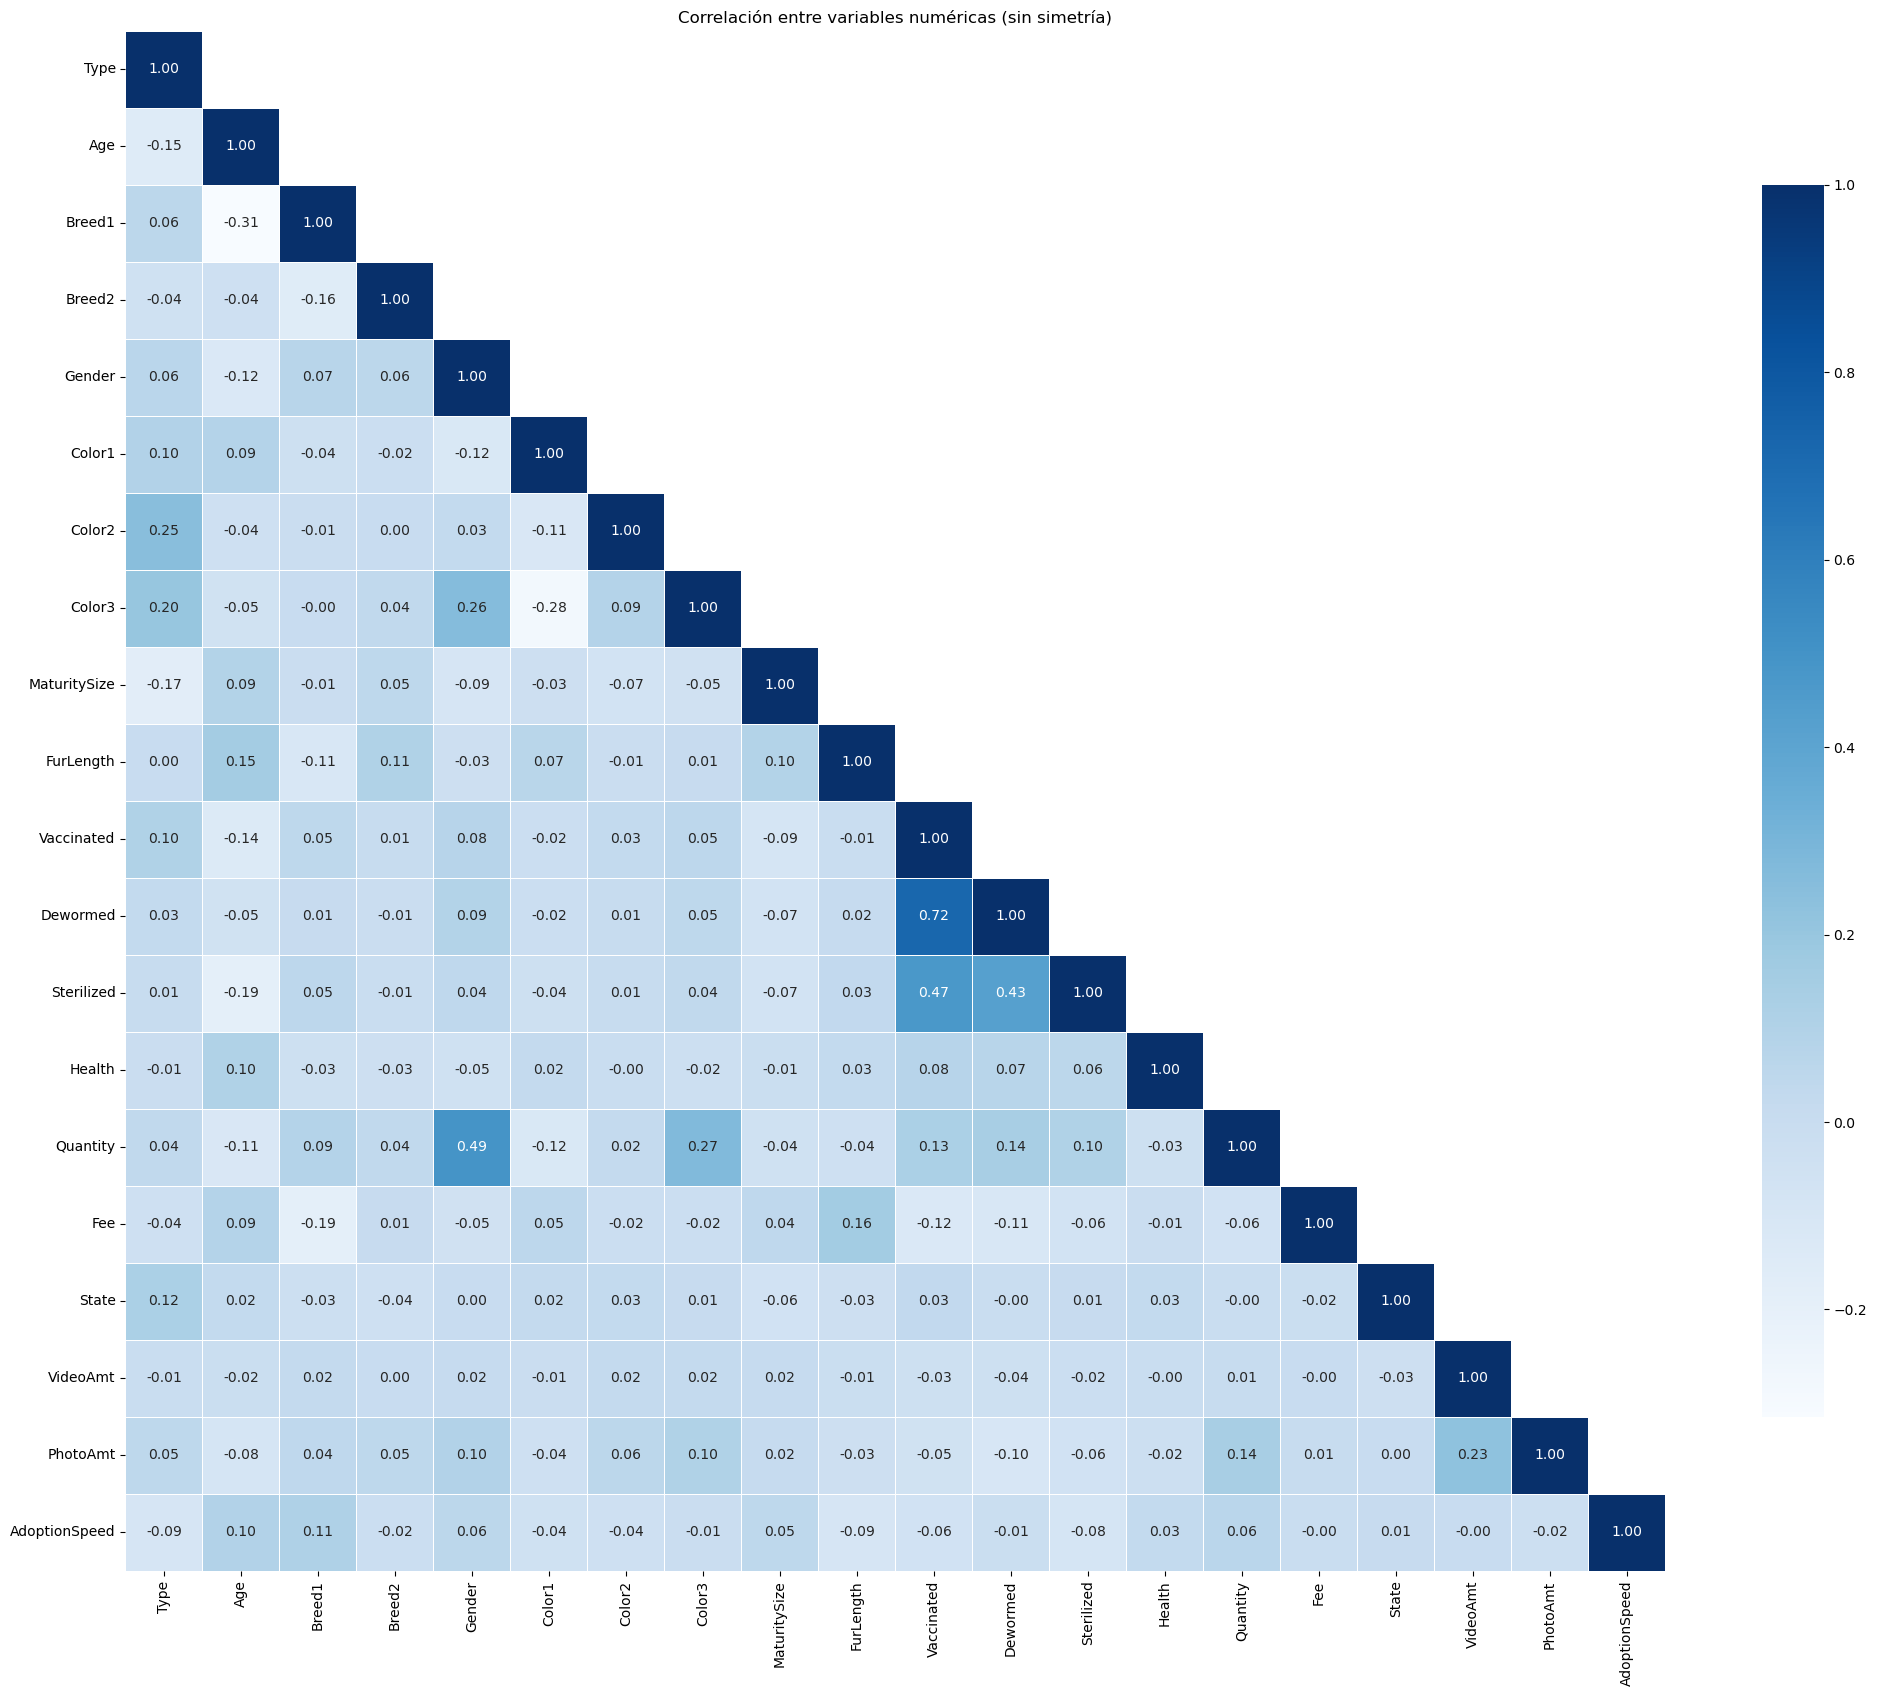

In [220]:
plt.figure(figsize=(25, 20))

df_corr = df.select_dtypes(['int64', 'float64']).corr()

# Máscara solo del triángulo superior EXCLUYENDO la diagonal
mask = np.triu(np.ones_like(df_corr, dtype=bool), k=1)

sns.heatmap(df_corr, mask=mask, annot=True, cmap='Blues', fmt=".2f", 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlación entre variables numéricas (sin simetría)')


### 🔎 Lectura del Heatmap

El heatmap de correlación permite identificar relaciones lineales entre variables numéricas del dataset. En esta etapa, se destacan algunos pares con correlaciones moderadas o altas que pueden ser relevantes para el análisis posterior:

- `Vaccinated` ~ `Dewormed`: r ≈ **0.72**  
- `Vaccinated` ~ `Sterilized`: r ≈ **0.47**  
- `Quantity` ~ `Gender`: r ≈ **0.49**

Estas asociaciones reflejan patrones consistentes con la lógica del dominio:

- Las variables relacionadas con intervenciones veterinarias (`Vaccinated`, `Dewormed`, `Sterilized`) suelen coexistir, lo cual puede reflejar prácticas sanitarias homogéneas entre rescatistas.
- La correlación entre `Quantity` y `Gender` podría estar asociada a diferencias en la cantidad de animales ofrecidos según su sexo, como camadas del mismo género o sesgos en la publicación.

> 🔁 Las autocorrelaciones (`r = 1.00`) se mantienen en la diagonal por motivos visuales, aunque carecen de interpretación analítica.

> 💡 A futuro, podría evaluarse la conveniencia de **agrupar o consolidar** las variables sanitarias en un solo indicador (por ejemplo, una variable que represente "atención médica completa"), reduciendo así la redundancia en el modelado predictivo.




---

### 🧠 Reflexión metodológica

El análisis de correlación es una herramienta útil para identificar relaciones entre variables numéricas. En esta etapa se utilizó el coeficiente de **Pearson**, que mide asociaciones lineales. Sin embargo, **esto no permite descartar completamente la presencia de multicolinealidad ni capturar relaciones no lineales o monotónicas**.

Existen escenarios en los que:

- Varias variables, aunque débilmente correlacionadas de forma individual, pueden en conjunto explicar otra de manera redundante.
- Relaciones no lineales o monotónicas no se reflejan correctamente con Pearson, por lo que puede considerarse el uso de **Spearman** en análisis complementarios.

🔍 Por estos motivos, se prevé complementar este análisis con herramientas más robustas en etapas posteriores del pipeline, como:

- **Variance Inflation Factor (VIF)** para detectar redundancia multivariada real.
- **Análisis de importancia de variables** en modelos predictivos supervisados.
- **Reducción de dimensionalidad (PCA)** en caso de alta redundancia estructural.

Estas técnicas se aplicarán luego del preprocesamiento y la ingeniería de variables, para garantizar una selección de features sólida, minimizando redundancias y maximizando la interpretabilidad del modelo.


## 🔹 2. Relación entre Variables Predictoras y la Variable Objetivo (`AdoptionSpeed`)

En esta sección se analiza cómo se relacionan las variables predictoras con la variable objetivo `AdoptionSpeed`, que representa la rapidez con la que una mascota es adoptada.

El objetivo de este análisis es:

- Detectar patrones multivariados relevantes.
- Identificar variables predictoras fuertes o débiles.
- Visualizar asociaciones complejas que no se perciben en análisis univariados.
- Evaluar la importancia relativa de las variables en el proceso de adopción.

Dado que `AdoptionSpeed` es una variable **ordinal discreta** (de 0 a 4), se abordan distintos tipos de análisis según el tipo de variable predictora.

Esta sección está estructurada en varios bloques:

---

### 🔸 2.1 Variables numéricas vs. `AdoptionSpeed`

Se exploran variables numéricas con gráficos tipo **boxplot**, **stripplot** y análisis de correlación de **Spearman**, útil para detectar relaciones no lineales pero monotónicas. Estas visualizaciones permiten observar cómo varían las distribuciones de características como `Age`, `PhotoAmt`, `Fee`, etc., según la rapidez de adopción.

---

### 🔸 2.2 Variables categóricas vs. `AdoptionSpeed`

Se analizan mediante **gráficos de barras** la distribución de adopciones para cada categoría, considerando variables como `Gender`, `Breed`, `Sterilized`, entre otras. Esto permite detectar categorías que tienden a tener mayor o menor velocidad de adopción.

---

### 🗺️ Distribución geográfica (`State` vs. `AdoptionSpeed`)

Se incorporan mapas interactivos construidos con **Folium**, que permiten visualizar por estado la cantidad de mascotas adoptadas en cada categoría de `AdoptionSpeed`. Esta visualización enriquece el análisis incluyendo una dimensión espacial del fenómeno de adopción.

---

### 🌲 Modelo exploratorio de importancia de variables

Se entrena un modelo simple de **Random Forest Classifier** para estimar la importancia relativa de las variables predictoras respecto a `AdoptionSpeed`. Esto complementa el análisis multivariado desde una perspectiva algorítmica y permite validar empíricamente las asociaciones detectadas previamente.

---



### 🔸 2.1 Variables Numéricas vs. `AdoptionSpeed`

En este bloque se analiza cómo se comportan las variables numéricas en relación con la variable objetivo `AdoptionSpeed`, que representa la rapidez con la que una mascota es adoptada (de 0 = adopción inmediata a 4 = sin adopción).

Dado que `AdoptionSpeed` es una variable **ordinal discreta**, se utilizaron herramientas visuales y estadísticas para explorar diferencias en la distribución de variables como `Age`, `PhotoAmt`, `Fee`, entre otras.

Los métodos aplicados fueron:

- 📊 **Boxplots**: permiten comparar la mediana, la dispersión y la presencia de outliers para cada categoría de adopción.
- 📈 **Correlación de Spearman**: permite detectar relaciones **monotónicas no lineales** entre variables numéricas y `AdoptionSpeed`.

> Estas visualizaciones ayudan a identificar patrones útiles para el modelado posterior y a justificar la transformación o selección de variables predictoras relevantes.  
> No se incluyeron `stripplots` ni `violinplots`, dado que las herramientas seleccionadas fueron suficientes para reflejar con claridad la información relevante.




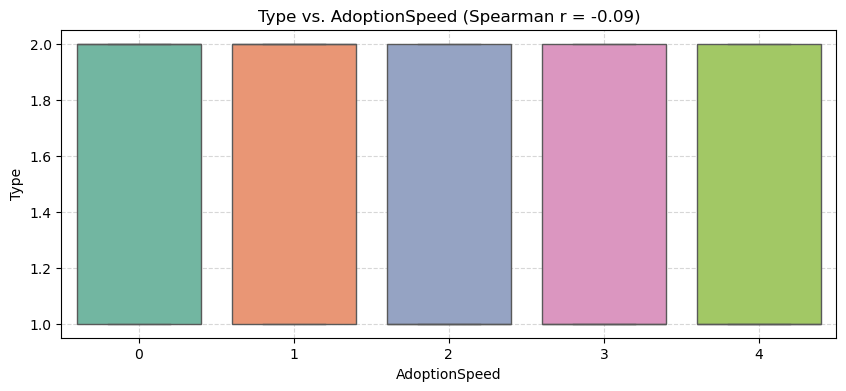

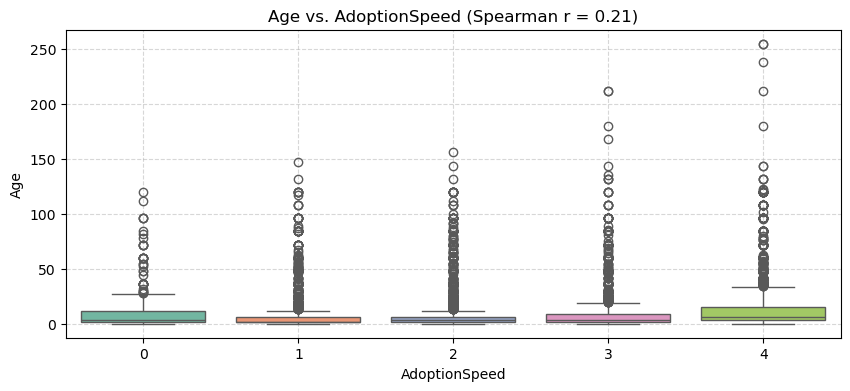

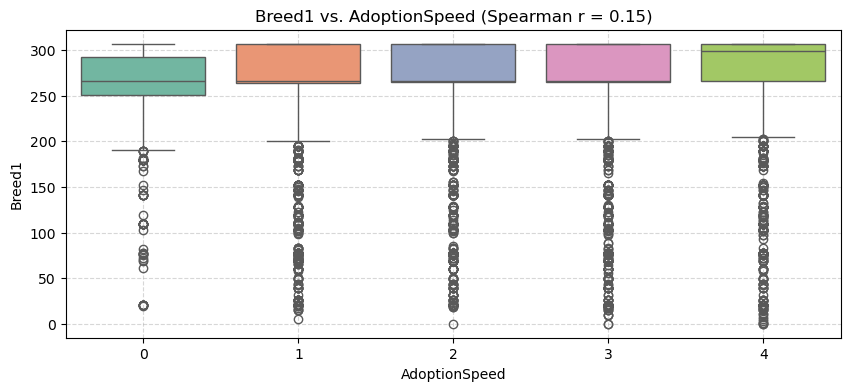

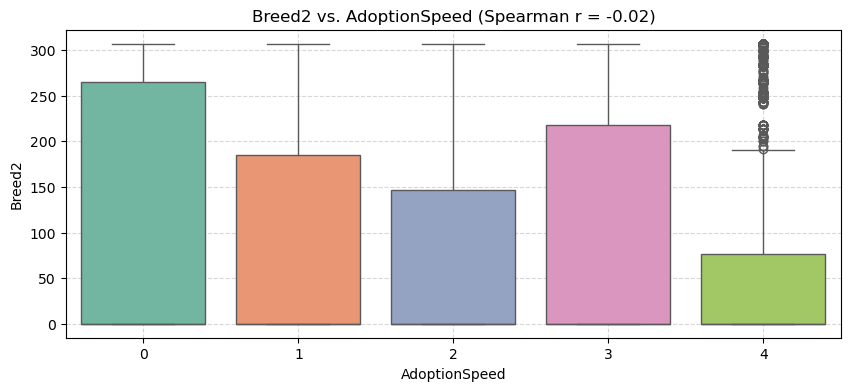

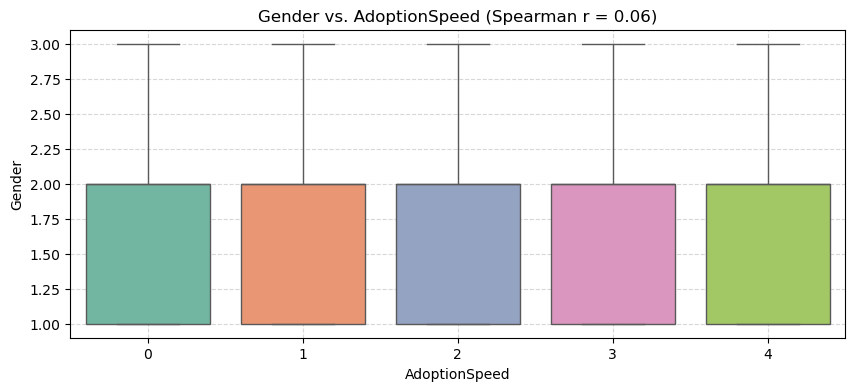

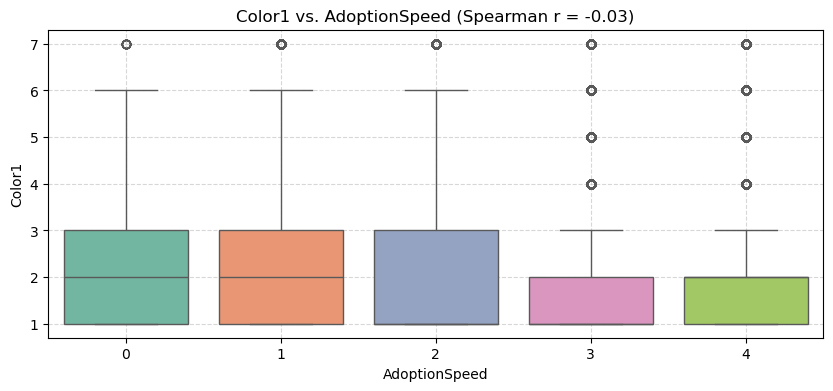

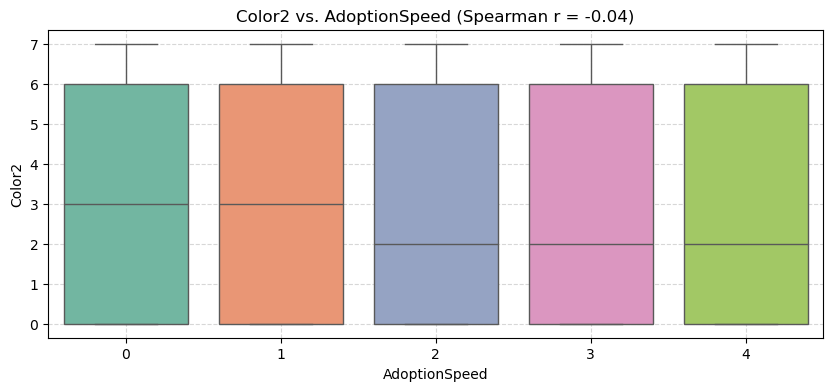

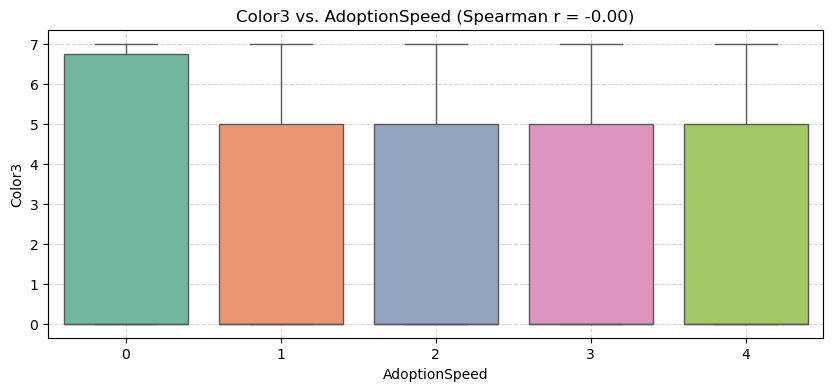

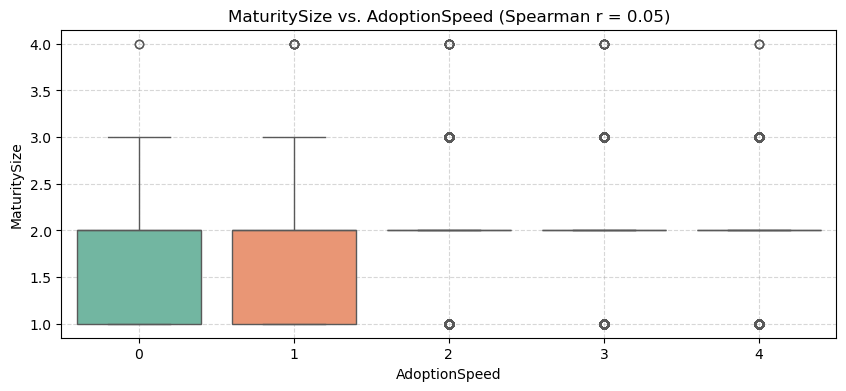

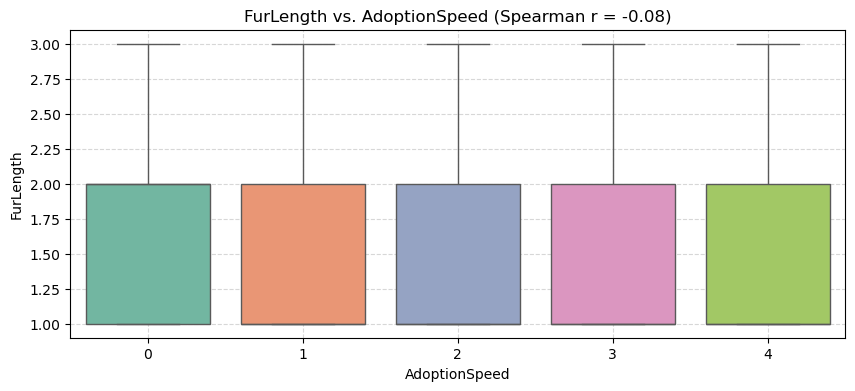

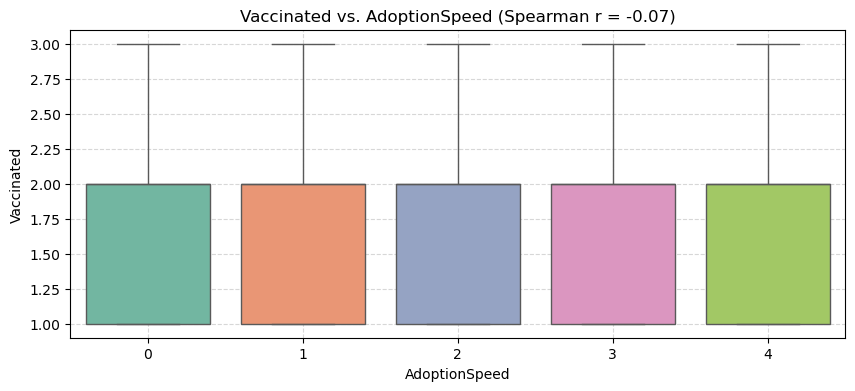

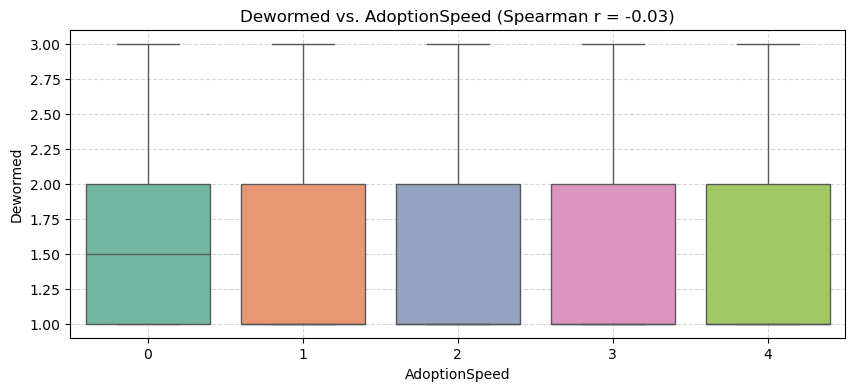

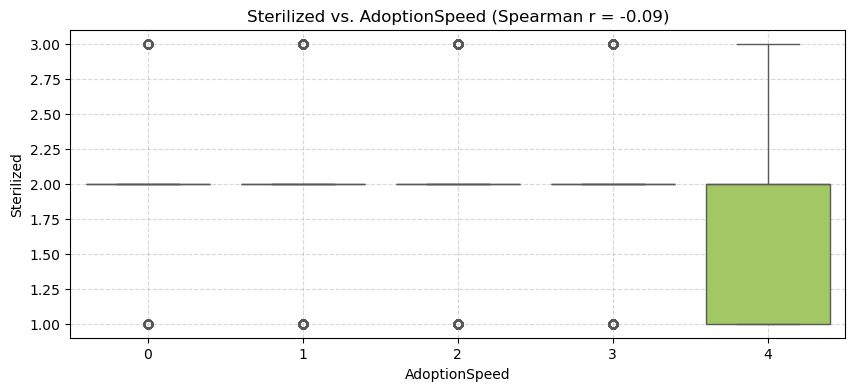

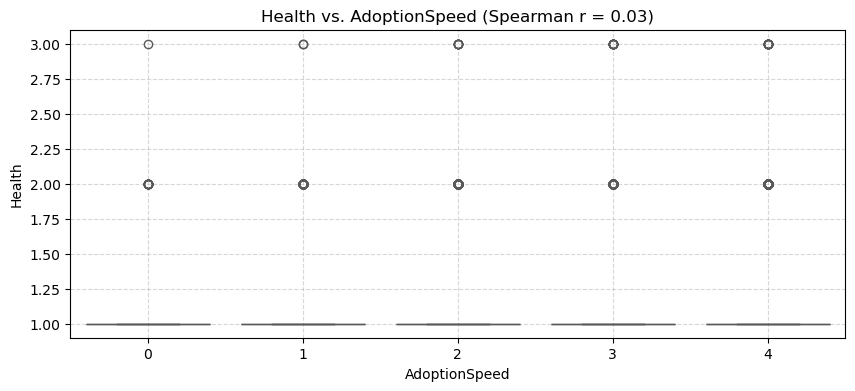

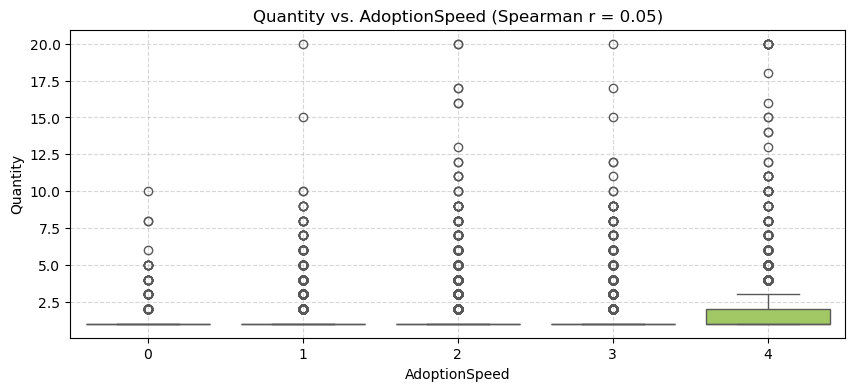

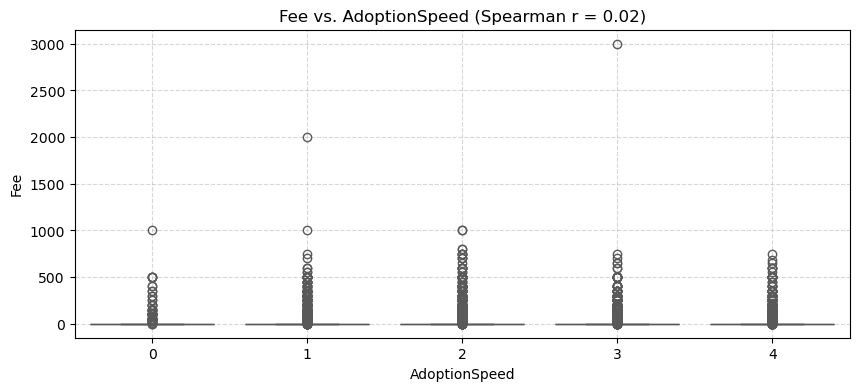

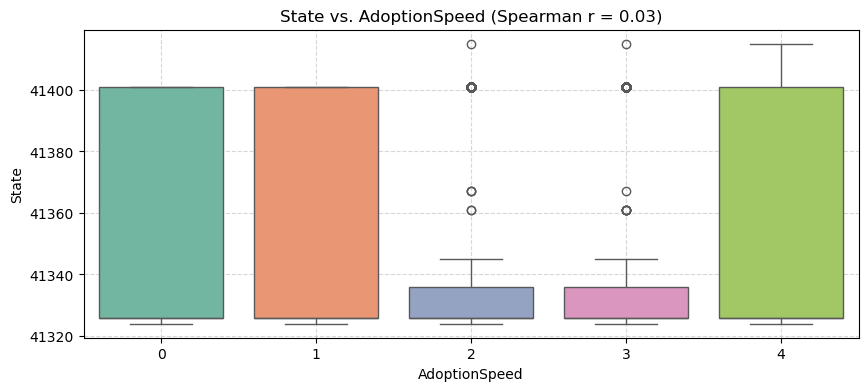

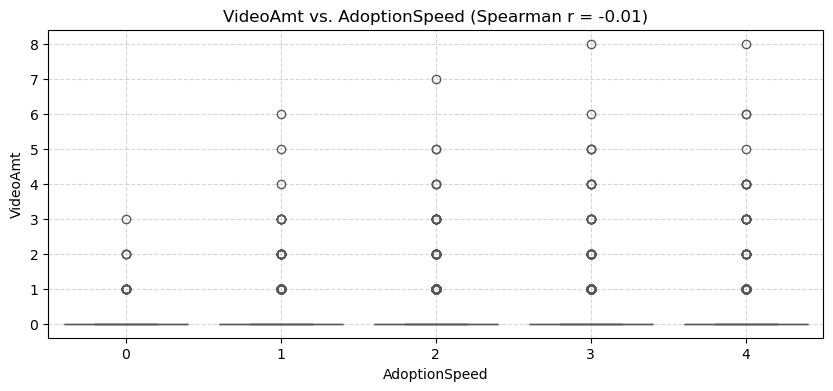

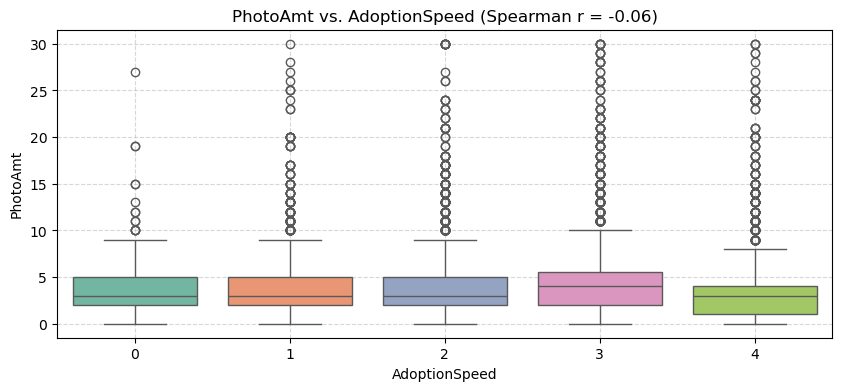

In [221]:
# Filtrar solo variables numéricas (excluyendo 'AdoptionSpeed')
numericas = df.select_dtypes(include=['int64', 'float64']).drop(columns='AdoptionSpeed').columns

# Gráficos combinados con Spearman en el título
for var in numericas:
    rho, _ = spearmanr(df[var], df['AdoptionSpeed'], nan_policy='omit')
    
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='AdoptionSpeed', y=var, data=df, palette='Set2')
    plt.title(f'{var} vs. AdoptionSpeed (Spearman r = {rho:.2f})')
    plt.xlabel('AdoptionSpeed')
    plt.ylabel(var)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

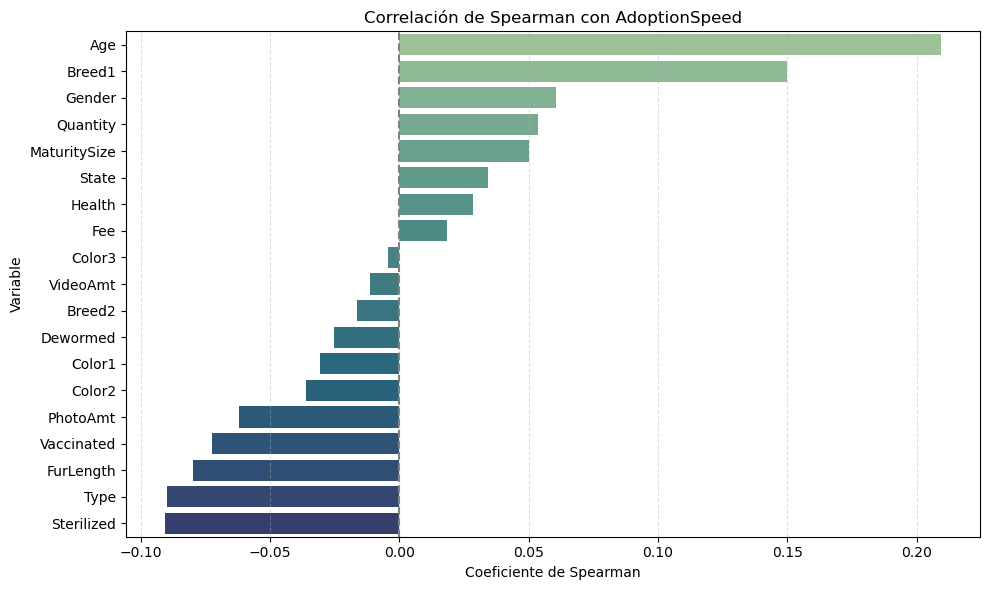

In [222]:
# Calculamos Spearman solo entre AdoptionSpeed y variables numéricas
numericas = df.select_dtypes(include=['int64', 'float64']).drop(columns='AdoptionSpeed').columns

correlaciones = {}

for var in numericas:
    rho, _ = spearmanr(df[var], df['AdoptionSpeed'], nan_policy='omit')
    correlaciones[var] = rho

cor_spearman_df = pd.DataFrame.from_dict(correlaciones, orient='index', columns=['Spearman_r'])
cor_spearman_df = cor_spearman_df.sort_values(by='Spearman_r', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=cor_spearman_df.Spearman_r, y=cor_spearman_df.index, palette='crest')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Correlación de Spearman con AdoptionSpeed')
plt.xlabel('Coeficiente de Spearman')
plt.ylabel('Variable')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### 🗺️ Distribución Geográfica por Velocidad de Adopción (`AdoptionSpeed`)

A continuación se visualiza la distribución de mascotas por estado en Malasia según la velocidad con la que fueron adoptadas (`AdoptionSpeed`). Cada mapa corresponde a una categoría ordinal de adopción, desde la más rápida (0) hasta la ausencia de adopción (4).

Los mapas están construidos con **Folium**, lo que permite explorar de forma interactiva cada estado pasando el mouse por encima para conocer la cantidad de mascotas correspondientes.

| Valor | Categoría               | Interpretación temporal                         |
|-------|--------------------------|--------------------------------------------------|
| **0** | 🟢 Adopción inmediata     | El mismo día de publicación                     |
| **1** | 🟡 Adopción rápida        | Entre 1 y 7 días                                 |
| **2** | 🟠 Adopción moderada      | Entre 8 y 30 días                                |
| **3** | 🔴 Adopción lenta         | Entre 31 y 90 días                               |
| **4** | ⚫ Sin adopción           | Más de 100 días                                 |

> 💡 *Esta visualización permite detectar regiones con mayor o menor tasa de adopción en cada categoría, facilitando el análisis multivariado geográfico del comportamiento de adopción.*


#### 📌 Reflexión metodológica

El uso de mapas geográficos permite identificar si la variable `State` tiene una asociación espacial relevante con la rapidez de adopción. Si bien esta variable por sí sola no explica completamente el fenómeno, **puede ser un importante complemento dentro de un enfoque multivariado**, ya que refleja condiciones regionales, acceso a centros de adopción, o nivel de urbanización.


In [223]:
df = df.merge(state_labels, left_on="State", right_on="StateID", how="left")
df["StateName_clean"] = df["StateName"].replace({
    "Melaka": "Malacca",
    "Pulau Pinang": "Penang"
}).fillna(df["StateName"])



for feature in geojson_data["features"]:
    original = feature["properties"]["shapeName"]
    feature["properties"]["StateName_clean"] = {
        "Melaka": "Malacca",
        "Pulau Pinang": "Penang"
    }.get(original, original)

# === 3. Definiciones de título por categoría ===
titulos = {
    0: "🟢 Adopción inmediata – Mismo día de publicación",
    1: "🟡 Adopción rápida – Entre 1 y 7 días",
    2: "🟠 Adopción moderada – Entre 8 y 30 días",
    3: "🔴 Adopción lenta – Entre 31 y 90 días",
    4: "⚫ Sin adopción – Más de 100 días"
}

# === 4. Calcular el máximo global ===
global_counts = df.groupby(["AdoptionSpeed", "StateName_clean"]).size().reset_index(name="count")
max_global_value = global_counts["count"].max()

# === 5. Crear mapas ===
for speed in sorted(df["AdoptionSpeed"].unique()):
    adopciones = df[df["AdoptionSpeed"] == speed].groupby("StateName_clean").size().reset_index(name="count")

    df_merge = pd.DataFrame({
        "StateName_clean": [f["properties"]["StateName_clean"] for f in geojson_data["features"]]
    }).merge(adopciones, on="StateName_clean", how="left").fillna(0)

    for feature in geojson_data["features"]:
        estado = feature["properties"]["StateName_clean"]
        cantidad = df_merge.loc[df_merge["StateName_clean"] == estado, "count"].values[0]
        feature["properties"]["Mascotas"] = int(cantidad)

    m = folium.Map(location=[4.5, 109.5], zoom_start=6, tiles="CartoDB positron")

    choropleth = folium.Choropleth(
        geo_data=geojson_data,
        name="choropleth",
        data=df_merge,
        columns=["StateName_clean", "count"],
        key_on="feature.properties.StateName_clean",
        fill_color="YlGnBu",
        fill_opacity=0.75,
        line_opacity=0.5,
        nan_fill_color="white",
        legend_name=f"Mascotas – AdoptionSpeed {speed}",
        threshold_scale=[
            0,
            max_global_value * 0.25,
            max_global_value * 0.5,
            max_global_value * 0.75,
            max_global_value
        ],
        reset=True
    ).add_to(m)

    tooltip = GeoJsonTooltip(
        fields=["StateName_clean", "Mascotas"],
        aliases=["Estado:", "Mascotas:"],
        labels=True,
        localize=True,
        sticky=False
    )
    choropleth.geojson.add_child(tooltip)

    # Título específico por categoría
    display(HTML(f"<h3 style='font-family:sans-serif;'>{titulos[speed]}</h3>"))
    display(m)


#### 📈 Interpretación del ranking de correlación de Spearman

El gráfico anterior resume las correlaciones de Spearman entre las variables numéricas y `AdoptionSpeed`, ordenadas de mayor a menor.

Se destacan algunas observaciones clave:

- Las correlaciones son en general **bajas a moderadas**, lo cual es esperable dado que muchas variables numéricas en este dataset no capturan directamente el comportamiento del adoptante.
- Algunas variables como `PhotoAmt` o `Fee` pueden mostrar **tendencias suaves**, donde un mayor número de fotos o precios más accesibles se asocian con una adopción más rápida.
- Otras variables como `Age` pueden tener correlación negativa, reflejando que los animales más jóvenes tienden a ser adoptados más rápidamente.

💡 Este tipo de análisis no busca identificar relaciones determinantes, sino **pistas para explorar en el modelado posterior**, donde podrán evaluarse efectos combinados, no lineales o segmentados por tipo de mascota.

---

📌 Se concluye así el análisis de las variables numéricas en relación con `AdoptionSpeed`. A continuación, se analizarán las variables **categóricas**, cuya relación con la variable objetivo puede resultar más evidente o segmentada.


### 🔸 2.2 Variables Categóricas vs. `AdoptionSpeed`

En este bloque se analiza cómo se relacionan las variables categóricas con la variable objetivo `AdoptionSpeed`.

Dado que `AdoptionSpeed` representa niveles ordinales de velocidad de adopción, este análisis permite detectar si ciertas categorías favorecen una adopción más rápida o más lenta.

Se utilizaron principalmente:

- **Countplots segmentados** (`hue='AdoptionSpeed'`): para visualizar la distribución de adopciones dentro de cada categoría de variables como `Gender`, `Sterilized`, `Vaccinated`, `Breed`, entre otras.

Además, para facilitar la visualización:

- Se agruparon las razas principales y secundarias menos frecuentes como `'Other'`, mostrando solo el top 10 de cada una.

> 💡 Este análisis es clave para identificar variables categóricas con alto poder discriminativo, lo cual es especialmente útil si se planea aplicar codificación posterior (como one-hot encoding o target encoding) en modelos predictivos.


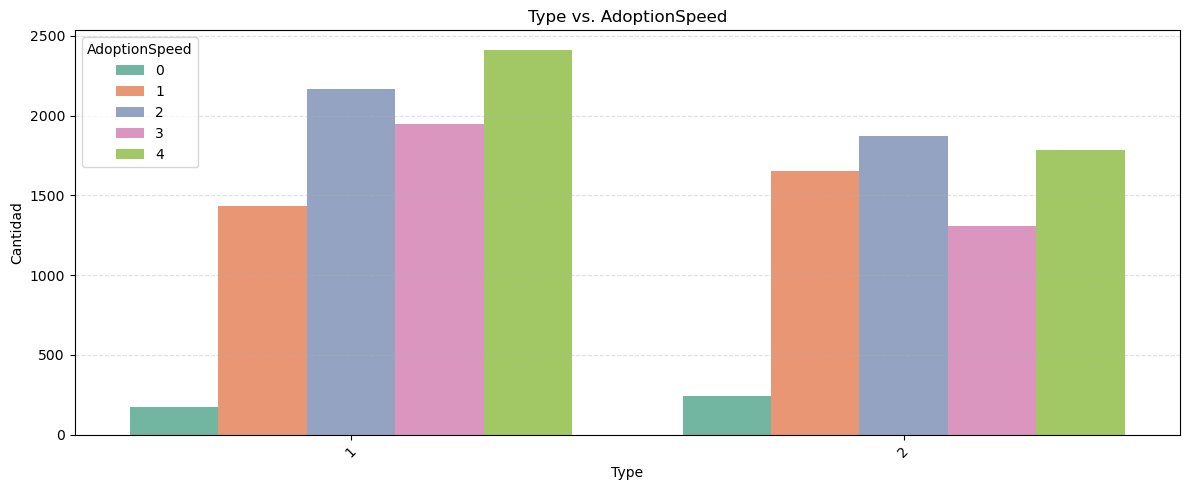

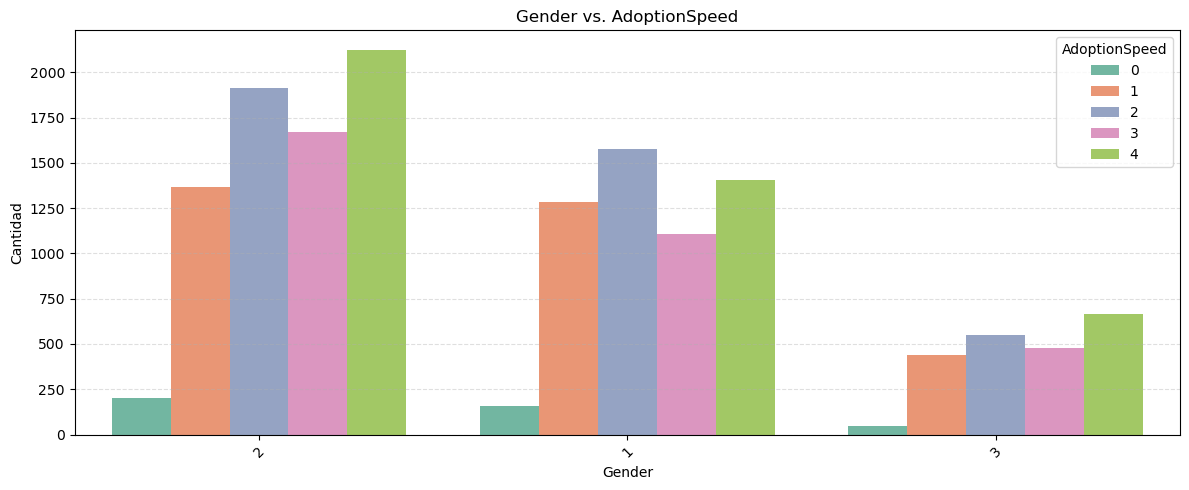

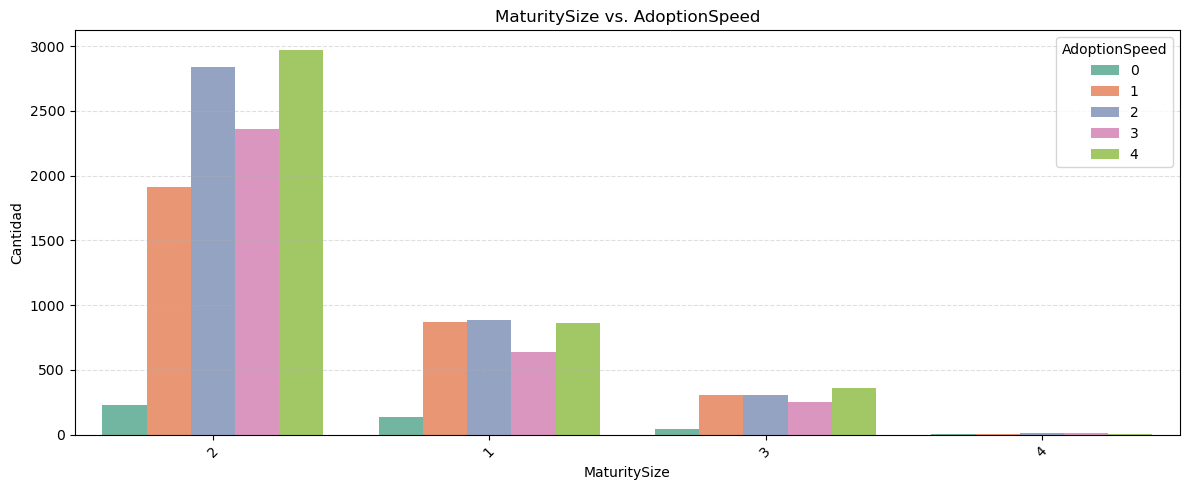

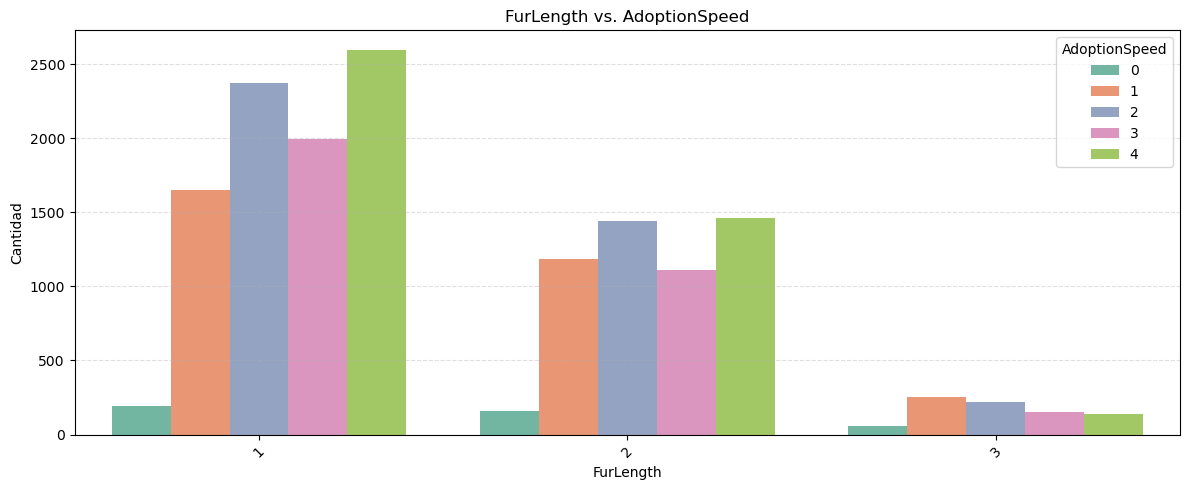

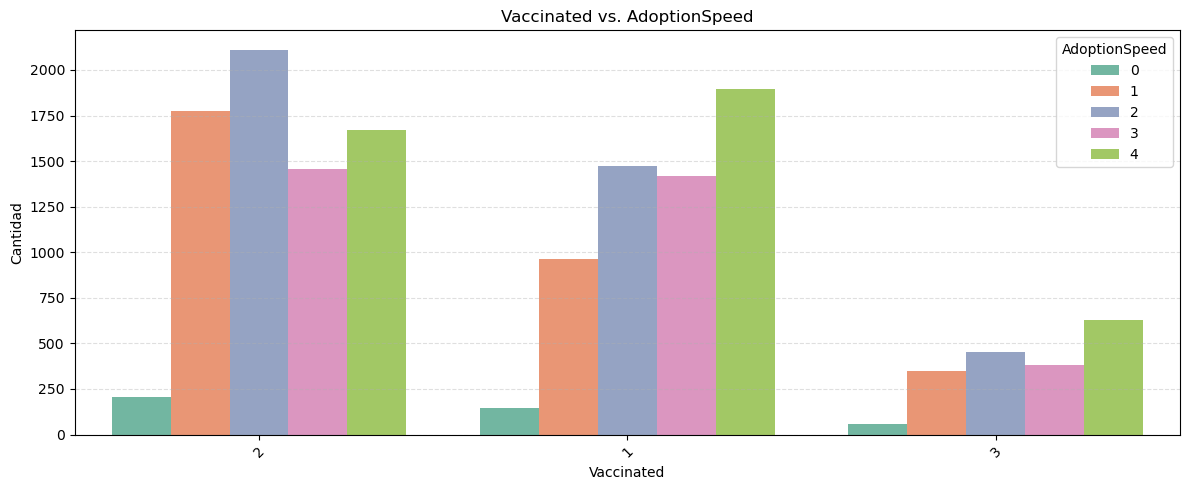

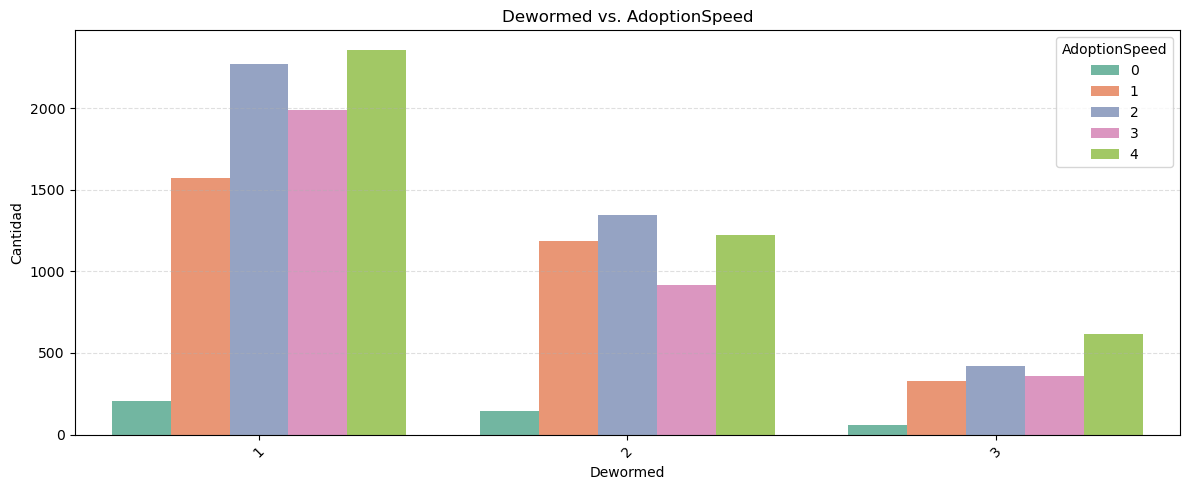

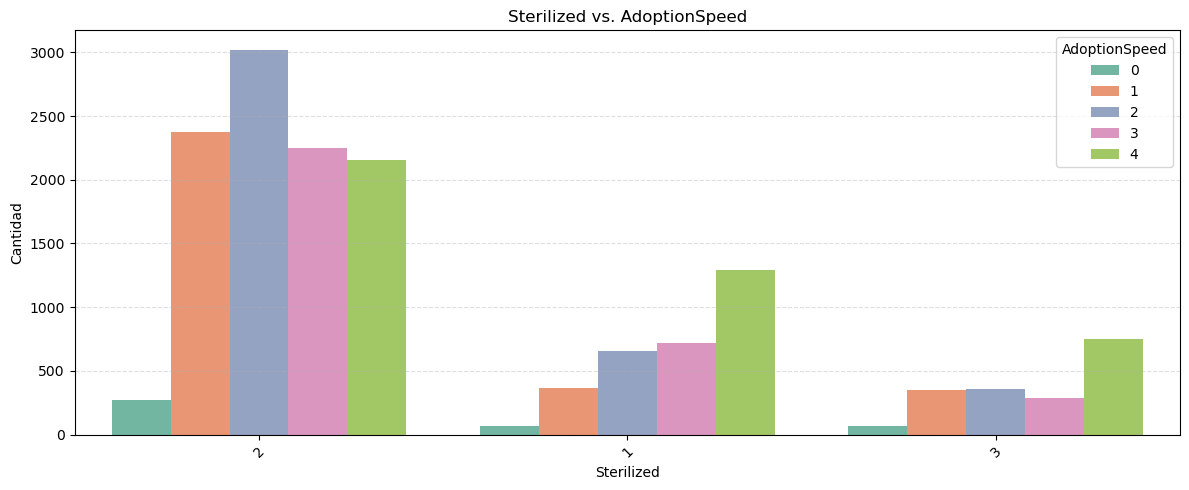

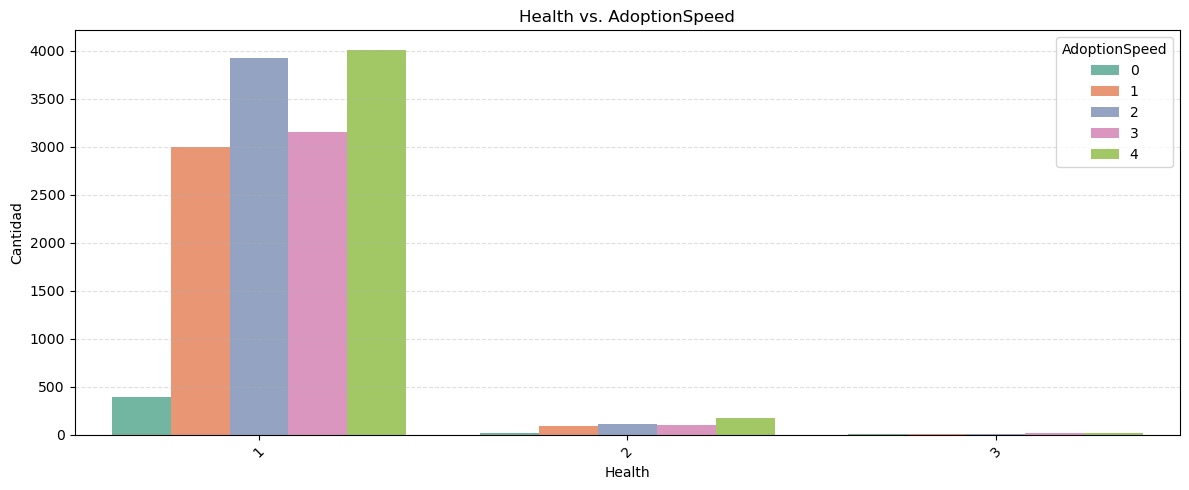

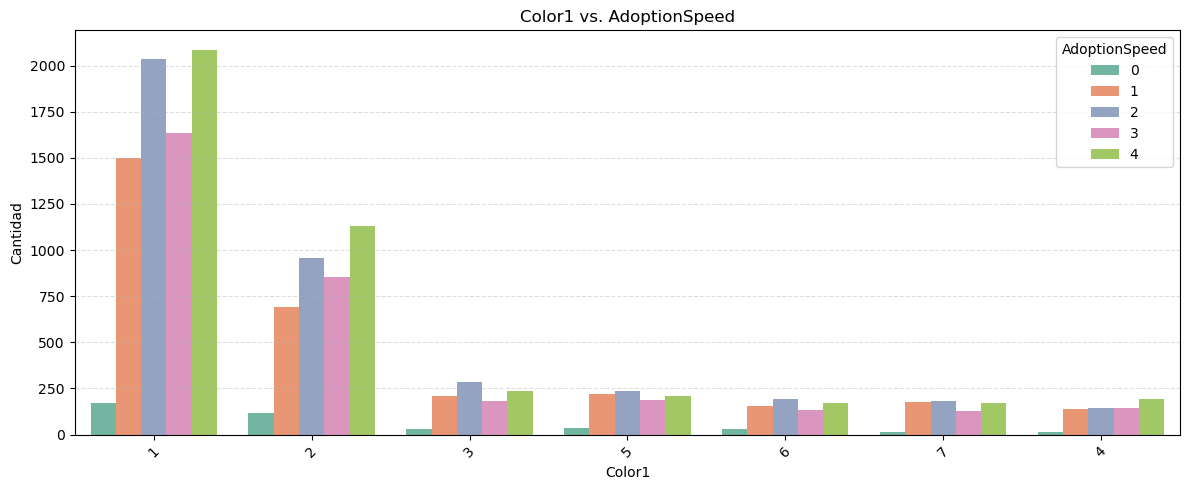

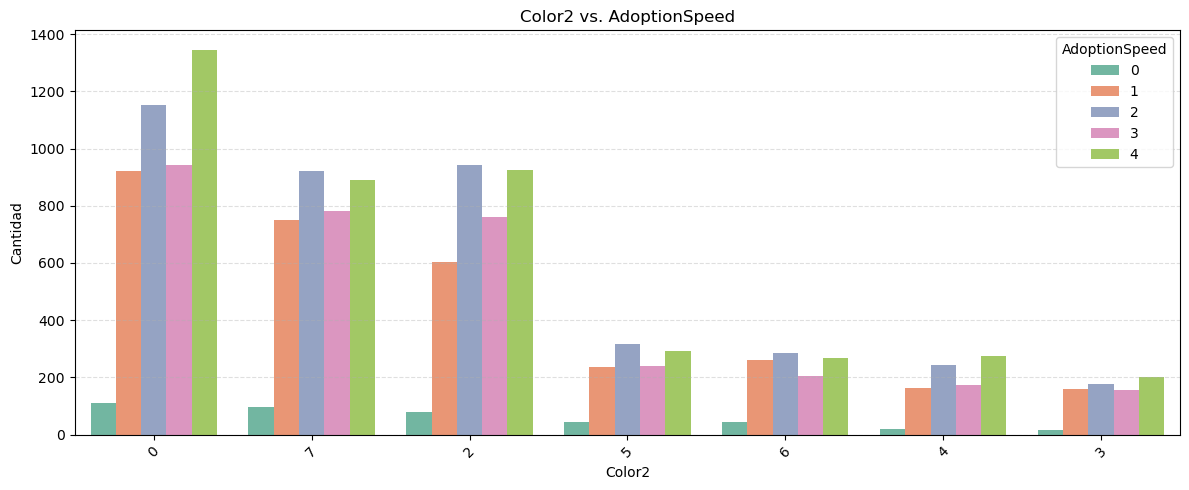

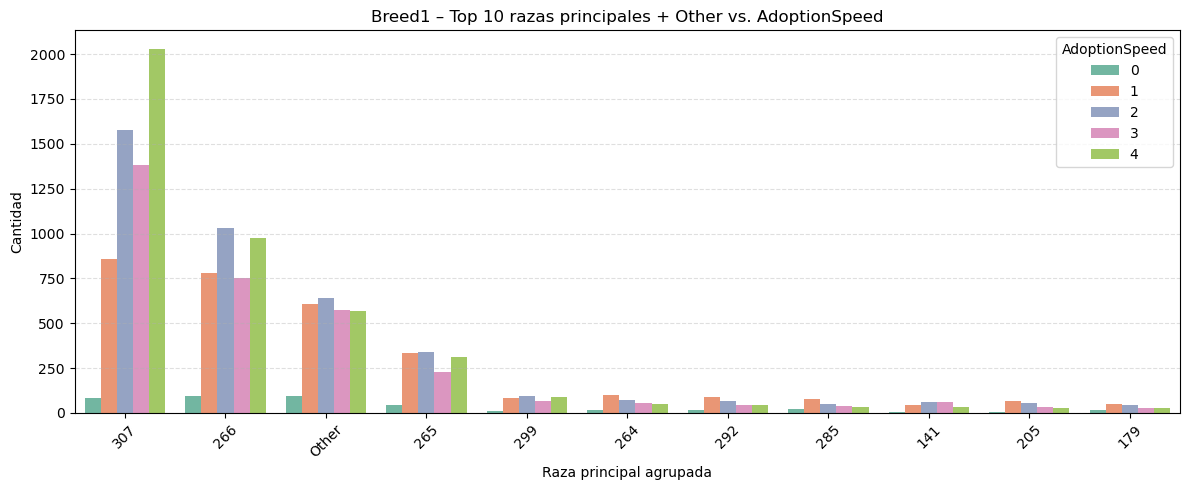

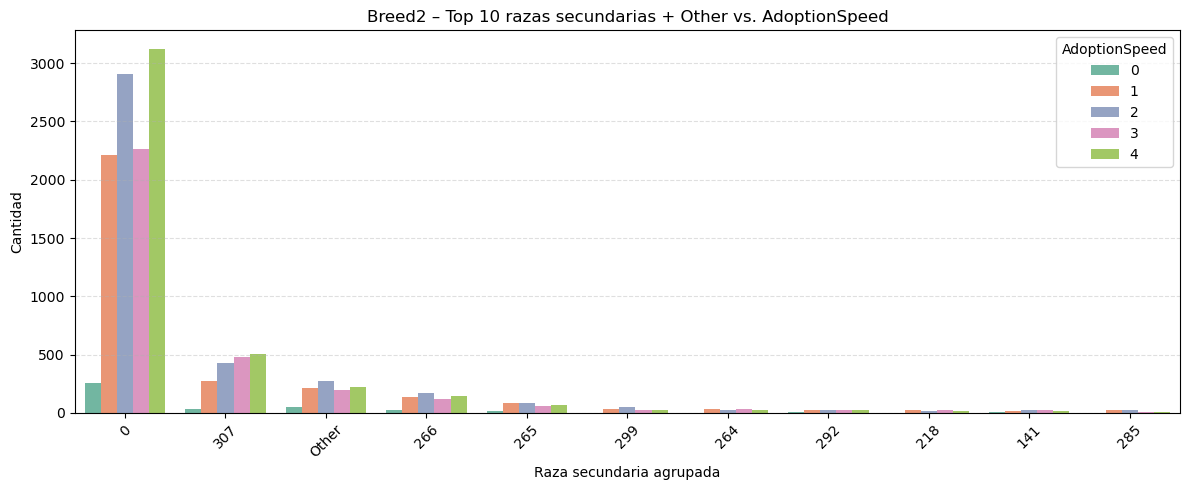

In [224]:
# Agrupar las 10 razas principales (Breed1) y secundarias (Breed2)
top_breed1 = df['Breed1'].value_counts().nlargest(10).index
top_breed2 = df['Breed2'].value_counts().nlargest(10).index

df['Breed1_Grouped'] = df['Breed1'].apply(lambda x: x if x in top_breed1 else 'Other')
df['Breed2_Grouped'] = df['Breed2'].apply(lambda x: x if x in top_breed2 else 'Other')

# Lista de variables categóricas que queremos graficar
vars_categoricas = ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated',
                    'Dewormed', 'Sterilized', 'Health', 'Color1', 'Color2',
                    'Breed1_Grouped', 'Breed2_Grouped']

# Gráfico por cada variable
for var in vars_categoricas:
    plt.figure(figsize=(12, 5))
    orden = df[var].value_counts().index
    sns.countplot(data=df, x=var, hue='AdoptionSpeed', order=orden, palette='Set2')

    # Títulos personalizados
    if var == 'Breed1_Grouped':
        plt.title('Breed1 – Top 10 razas principales + Other vs. AdoptionSpeed')
        plt.xlabel('Raza principal agrupada')
    elif var == 'Breed2_Grouped':
        plt.title('Breed2 – Top 10 razas secundarias + Other vs. AdoptionSpeed')
        plt.xlabel('Raza secundaria agrupada')
    else:
        plt.title(f'{var} vs. AdoptionSpeed')
        plt.xlabel(var)

    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()




### 🧩 Relación entre Variables Categóricas y AdoptionSpeed

En esta sección se analizaron las variables categóricas más relevantes del dataset en relación con la variable objetivo `AdoptionSpeed`.  
El objetivo fue identificar posibles patrones, diferencias entre categorías y asociaciones relevantes para etapas posteriores de modelado.

Entre los hallazgos destacados:

- **Variables veterinarias** como `Vaccinated`, `Dewormed` y `Sterilized` presentan distribuciones diferenciadas en función de la velocidad de adopción.
- **Tamaño y pelaje** (`MaturitySize`, `FurLength`) también muestran tendencias visibles, sugiriendo que ciertas características físicas podrían influir en la decisión de adopción.
- **Género y tipo de animal** (`Gender`, `Type`) reflejan diferencias notables entre categorías.
- Para `Breed1` y `Breed2`, debido a su **alta cardinalidad**, se agruparon en una nueva variable que incluye:
  - Las **10 razas más frecuentes**
  - Una categoría adicional denominada `"Other"` para todas las demás

> 📝 Este tipo de agrupamiento no solo mejora la legibilidad visual, sino que también **reduce dimensionalidad** y **minimiza el riesgo de sobreajuste** en futuros modelos predictivos.

---

📌 Estos análisis permiten seleccionar, transformar o priorizar ciertas variables categóricas en función de su aporte explicativo respecto a la variable objetivo.  
Se complementarán con técnicas adicionales de selección de variables en etapas posteriores.


### 🔸 3. Importancia Relativa de Variables (Modelo Exploratorio)

Para complementar el análisis multivariado, se ajustó un **modelo exploratorio** con el objetivo de evaluar la importancia relativa de las variables predictoras en la estimación de `AdoptionSpeed`.

Se optó por un **Random Forest Classifier**, un modelo robusto que permite:

- Capturar relaciones no lineales entre variables
- Evaluar automáticamente la relevancia de cada feature
- Trabajar con variables numéricas y categóricas codificadas sin requerir normalización previa

⚠️ Cabe destacar que este modelo no busca obtener predicciones óptimas, sino servir como **herramienta de diagnóstico** para detectar qué variables tienen mayor poder explicativo.

A continuación, se presenta el proceso paso a paso.


#### 🧪 Preparación de datos para el modelo exploratorio

Se seleccionaron las variables predictoras más relevantes y se codificaron las variables categóricas mediante `LabelEncoder`, una técnica simple que asigna un número a cada categoría.

Esta codificación es suficiente para modelos de árboles como Random Forest, ya que no requieren representaciones ortogonales (como one-hot) para procesar datos categóricos.



In [225]:
# Copia del dataset original
df_model = df.copy()

# Codificación de variables categóricas con LabelEncoder
le = LabelEncoder()

for col in df_model.select_dtypes(include=['object', 'category']).columns:
    df_model[col] = le.fit_transform(df_model[col].astype(str))

# Agregamos también Breed1_Grouped y Breed2_Grouped si aún no están codificadas
for col in ['Breed1_Grouped', 'Breed2_Grouped']:
    if col in df_model.columns:
        df_model[col] = le.fit_transform(df_model[col].astype(str))

# Variables predictoras (X) y target (y)
X = df_model.drop(columns=['AdoptionSpeed', 'Name', 'Description', 'PetID', 'RescuerID'])
y = df_model['AdoptionSpeed']


#### 🌲 Entrenamiento del modelo Random Forest y obtención de importancias

Con los datos preparados, se entrenó un modelo de clasificación `RandomForestClassifier` para predecir `AdoptionSpeed`.

Este modelo permite obtener de forma directa la **importancia relativa** de cada variable, en función del aporte que hace a las decisiones de clasificación dentro del bosque de árboles.

> 📌 Recordemos que esto no busca construir un modelo definitivo, sino obtener un primer diagnóstico sobre las variables que más contribuyen a explicar la velocidad de adopción.


### 🌲 Importancia de Variables según Modelo Random Forest

Se entrenó un modelo exploratorio de **Random Forest** para estimar la **importancia relativa de las variables predictoras** sobre la velocidad de adopción (`AdoptionSpeed`).

Este tipo de análisis permite identificar qué variables tienen mayor impacto en las decisiones del modelo, considerando posibles interacciones y relaciones no lineales.  
Se utiliza en esta etapa como una herramienta práctica para:

- Priorizar atributos para etapas posteriores de modelado.
- Validar (o cuestionar) lo observado en los análisis multivariados.
- Obtener un ranking objetivo de relevancia de variables.



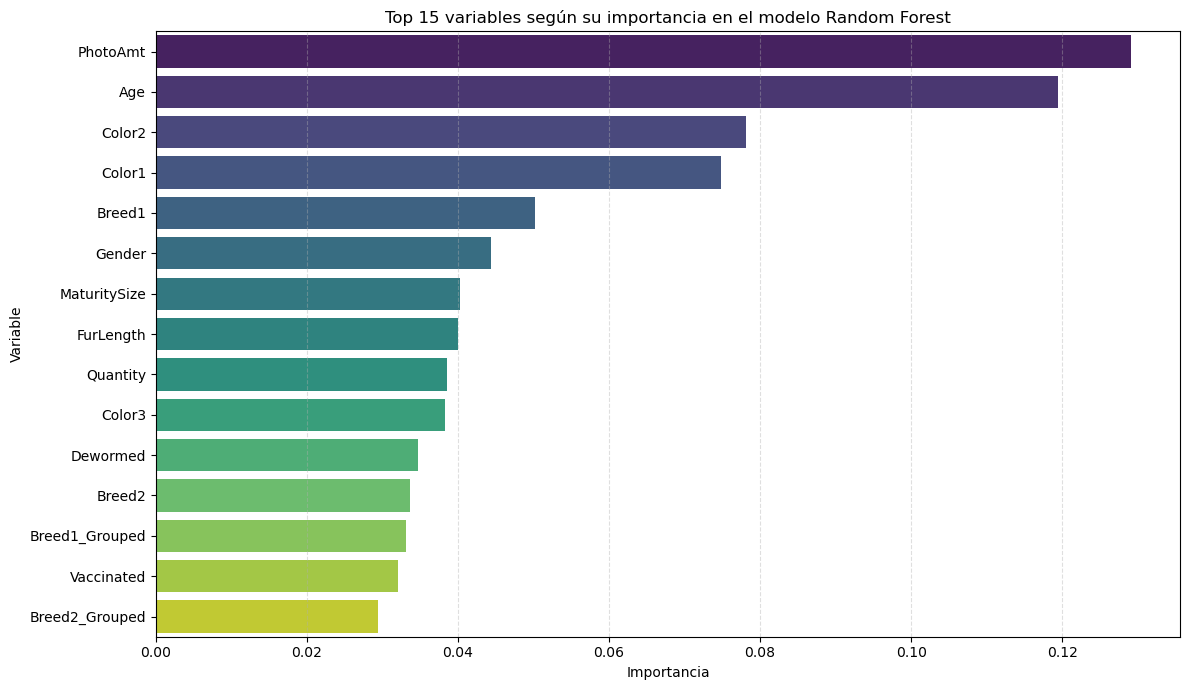

In [226]:
# Entrenar el modelo Random Forest
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X, y)

# Extraer importancias
importancias = modelo.feature_importances_
features = X.columns
df_importancias = pd.DataFrame({'Variable': features, 'Importancia': importancias})
df_importancias = df_importancias.sort_values(by='Importancia', ascending=False)

# Graficar
plt.figure(figsize=(12, 7))
sns.barplot(x='Importancia', y='Variable', data=df_importancias.head(15), palette='viridis')
plt.title('Top 15 variables según su importancia en el modelo Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### 📌 Interpretación de resultados

El gráfico muestra las **15 variables más influyentes**, ordenadas de mayor a menor:

- 📸 **`PhotoAmt`** lidera el ranking, indicando que un mayor número de fotos mejora la visibilidad y favorece la adopción.
- 👶 **`Age`** (edad en meses) aparece como segunda, lo que sugiere preferencia por animales más jóvenes.
- 🎨 **`Color1`, `Color2`, `Color3`** evidencian que las características visuales tienen peso.
- 🏠 **`State`**, **`Breed1`** y **`Breed2`** reflejan influencia de ubicación y raza.
- 🧬 Otras variables como **`Gender`, `FurLength`, `Quantity`** aportan en menor medida.
- 💉 Factores médicos como `Dewormed` y `Vaccinated` quedan al final del ranking. No implica irrelevancia, sino menor poder discriminante para este modelo.

> ⚠️ *Este análisis es exploratorio. La importancia puede variar con otras configuraciones o modelos, pero sirve como base sólida para la selección inicial de variables predictoras.*


---

## ✅ Conclusiones del Análisis Multivariado

El análisis multivariado nos permitió comprender con mayor profundidad cómo se relacionan las variables del dataset entre sí y con la variable objetivo `AdoptionSpeed`.

A partir del recorrido realizado, se destacan tres grandes conclusiones:

1. **Estructura interna controlada:**  
   No se detectaron relaciones que sugieran multicolinealidad severa entre variables predictoras. Las correlaciones moderadas fueron documentadas y serán tenidas en cuenta para futuras etapas de modelado.

2. **Relaciones con la variable objetivo:**  
   Se identificaron asociaciones interesantes entre algunas variables y `AdoptionSpeed`. Por ejemplo:
   - Mayor cantidad de fotos (`PhotoAmt`) se asocia a adopciones más rápidas.
   - Variables como edad, tamaño y características visuales también muestran patrones relevantes.

   🔍 **Nota metodológica:**  
   En esta etapa se utilizó el **coeficiente de correlación de Spearman**, que permite capturar relaciones **monótonas** (lineales o no).  
   Sin embargo, podrían existir relaciones más complejas **no monótonas** (ej. en forma de U o curvilíneas) que escapen tanto a Pearson como a Spearman.  
   Estas se evaluarán posteriormente mediante técnicas basadas en árboles o modelos no lineales más expresivos.

3. **Importancia de variables según modelo exploratorio:**  
   El modelo Random Forest permitió jerarquizar las variables por su aporte predictivo. Estas señales serán clave para una **futura selección de features más robusta**, acompañada posiblemente por métodos como:
   - Análisis de VIF (Factor de Inflación de Varianza)
   - Reducción de dimensionalidad (PCA)
   - Modelos ajustados con validación cruzada y optimización de hiperparámetros

---


# 🛠️ Feature Engineering: Construcción y Evaluación de Nuevas Variables

Una vez finalizado el análisis exploratorio univariado y multivariado, se procedió a la construcción de variables derivadas con el objetivo de:

- Mejorar la interpretabilidad.
- Codificar relaciones implícitas en el dominio.
- Preparar el dataset para su uso posterior en modelos predictivos.

Estas transformaciones fueron guiadas por los hallazgos estadísticos previos.  
En particular, algunas variables derivadas se construyeron **después** del análisis multivariado para **no introducir correlaciones artificiales** que pudieran distorsionar la matriz de correlación o el comportamiento del dataset.

> 📌 Por ejemplo, la variable `AgeYear` (edad expresada en años) fue creada por conveniencia interpretativa, pero **no fue incorporada al análisis multivariado** debido a su colinealidad perfecta con `Age`.

### 🔹 Variable `AgeYear` (Edad en años)

Se creó la variable `AgeYear` dividiendo la edad original (`Age`, expresada en meses) por 12, con el objetivo de facilitar su interpretación.

```python
df["AgeYear"] = df["Age"] / 12


In [231]:
# 🐾 Edad en años (AgeYear)
df["AgeYear"] = df["Age"] / 12


### 🔹 Variable `HealthScore` (Nivel de atención veterinaria)

Dado que las variables `Vaccinated`, `Dewormed` y `Sterilized` mostraron alta correlación entre sí (r ≈ 0.7), se construyó una variable sintética llamada `HealthScore`.

Esta nueva variable representa el **nivel de atención veterinaria** recibido por la mascota, calculado como la **suma de los tres indicadores sanitarios**, que asumen valores:

- `1`: sí
- `2`: no
- `3`: no se sabe

Para consolidar esta información de manera consistente, primero se transformaron los valores para que `1` signifique atención positiva (`Sí`) y los demás sean 0:

df["Vaccinated_Bin"] = (df["Vaccinated"] == 1).astype(int)
df["Dewormed_Bin"] = (df["Dewormed"] == 1).astype(int)
df["Sterilized_Bin"] = (df["Sterilized"] == 1).astype(int)
df["HealthScore"] = df[["Vaccinated_Bin", "Dewormed_Bin", "Sterilized_Bin"]].sum(axis=1)


In [234]:
df["Vaccinated_Bin"] = (df["Vaccinated"] == 1).astype(int)
df["Dewormed_Bin"] = (df["Dewormed"] == 1).astype(int)
df["Sterilized_Bin"] = (df["Sterilized"] == 1).astype(int)
df["HealthScore"] = df[["Vaccinated_Bin", "Dewormed_Bin", "Sterilized_Bin"]].sum(axis=1)
# Esta variable resume el nivel de atención sanitaria recibido por la mascota,
# y permite capturar su efecto combinado sin introducir multicolinealidad,
# ya que las variables originales presentaban correlaciones altas entre sí.


> Esta transformación busca representar de forma más sintética y robusta el impacto del cuidado veterinario, reduciendo la redundancia estadística sin perder información relevante para el modelado.


# Modelos

## RandomForest

In [227]:
X = df.drop(columns=['Name', 'Description', 'AdoptionSpeed', 'RescuerID', 'PetID'])
y = df['AdoptionSpeed']

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, shuffle=True, test_size=0.2)

In [229]:
rf = RandomForestClassifier(random_state=7)

**Asignarle enteros a los ids de rescatistas.**

In [230]:
rf.fit(X_train, y_train)

ValueError: could not convert string to float: 'Selangor'

In [ ]:
y_pred = rf.predict(X_test)

# Backlog

* Agregar comentarios en cada celda
* Análisis Multivariado